<h1><center>Predicting Malaria Burden in Uganda Through Socioeconomic Indicators and Housing Characteristics</center></h1>

This notebook implements the end-to-end workflow for preparing and modeling a dataset aimed at predicting malaria burden in Uganda using socioeconomic and housing-related indicators. It includes data cleaning, exploratory analysis, feature engineering, model training, and evaluation.

### Notebook Structure

1. **Imports and Setup**  
   Load required libraries/packages

2. **Data Loading and Initial Inspection**  
   Load and merge the datasets and examine the basic structure.

3. **Data Cleaning**  
   Handle missing values, outliers, variable transformations, and standardization.

4. **Exploratory Data Analysis (EDA)**  
   Explore distributions, relationships, and potential predictors of malaria.

5. **Feature Engineering**  
   Construct and select relevant features, with a focus on variables related to housing quality (e.g., wall and floor materials) and socioeconomic status (e.g., asset ownership and household size). This step also includes recoding, creating derived variables, and preparing features for modeling.

6. **Model Training and Evaluation**  
   Fit and evaluate machine learning models including logistic regression, random forest, gradient boosting and XGBoost.

7. **Model Comparison and Interpretation**  
   Compare model performance metrics and interpret feature importance.

In [1]:
# Core Libraries
import numpy as np
import pandas as pd
from time import time

# Data Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
import plotly.express as px
import seaborn as sns

# Statistical Analysis
import scipy.stats as stats
from scipy.stats import ttest_ind, chi2_contingency
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.discrete.discrete_model import Logit

# Machine Learning - Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

# Machine Learning - Models
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Lasso, LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Machine Learning - Metrics
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    classification_report
)

# Utilities
from tqdm import tqdm

# Import and merge data

In [2]:
# Keeping track of the time it takes to run all the code
start = time()

In [3]:
# Load the data - there are three data files - tab delimited text files
df_households = pd.read_csv('data/LLINE-UP_rct_Households.txt', delimiter='\t', low_memory=False)
df_participants = pd.read_csv('data/LLINE-UP_rct_Participants.txt', delimiter='\t', low_memory=False)
df_samples = pd.read_csv('data/LLINE-UP_rct_Samples.txt', delimiter='\t')

In [4]:
# Merge the three dataframes into one large dataframe

# Merge participants with samples
df_merged = df_participants.merge(
    df_samples.drop(columns=["Household_Id", "Community_Id"], errors="ignore"),
    on="Participant_Id",
    how="left"
)

# Merge with households
df_merged = df_merged.merge(df_households, on="Household_Id", how="left")

# Drop all ID columns
df_merged = df_merged.drop(columns=["Participant_Id", "Sample_Id", "Community_Id", "Household_Id"], 
                           errors="ignore")

In [5]:
# Drop these columns as they are not needed - they do not contain
# information about SES or household characteristics
columns_to_drop = [
    'Participant_Id', 'Sample_Id', 'Community_Id', 'Household_Id', 'Community_Id_x', 'Community_Id_y',
    'Acres categorization [EUPATH_0020221]', 'Age group [EUPATH_0010367]', 'Arthropods surveyed [EUPATH_0044118]',
    'Blood smear barcode [CLINEPIDB_00662]', 'Bloodfed Anopheles funestus count [EUPATH_0000192]',
    'Bloodfed Anopheles gambiae count [EUPATH_0000193]', 
    'Community health worker has malaria medication [EUPATH_0020229]',
    'Community health worker present [EUPATH_0020230]', 'Collection date [EUPATH_0020003]',
    'Eligible for clinical survey [EUPATH_0044101]', 'Enumeration area ID [EUPATH_0044123]', 
    'Febrile [EUPATH_0000097]', 'Female Anopheles count [EUPATH_0000135]', 
    'Female Anopheles funestus count [EUPATH_0000136]', 'Female Anopheles gambiae count [EUPATH_0000137]', 
    'Female non-Anopheline count [EUPATH_0044116]', 'Filter paper barcode [CLINEPIDB_00661]', 
    'Gravid Anopheles funestus count [EUPATH_0000197]', 'Gravid Anopheles gambiae count [EUPATH_0000198]', 
    'Health facility distance categorization [EUPATH_0020214]', 'Hemoglobin (g/dL) [CMO_0000026]', 
    'Household bednets [EUPATH_0020232]', 'Household data collection date [EUPATH_0021085]',
    'Household ITNs [EUPATH_0044136]', 'Household study timepoint [EUPATH_0044122]', 
    'ITN bednet count categorization [EUPATH_0044126]', 'Male Anopheles count [EUPATH_0025031]', 
    'Male Anopheles funestus count [EUPATH_0044102]', 'Male Anopheles gambiae count [EUPATH_0044104]',
    'Male non-Anopheline count [EUPATH_0044117]', 'Meals per day categorization [EUPATH_0020237]', 
    'Meat meals per week categorization [EUPATH_0020238]', 'Bednet count categorization [EUPATH_0020226]', 
    'Non-UCC bednets [EUPATH_0044141]', 'Observation date [EUPATH_0004991]',
    '1 ITN per 2 people [EUPATH_0044135]', 'One bednet per 2 people [EUPATH_0020219]', 
    'Other female Anopheles species count [EUPATH_0000200]', 'Other male Anopheles species count [EUPATH_0044106]', 
    'Persons 5-15 years sleeping in dwelling count [EUPATH_0044164]',
    'Persons 5-15 years sleeping under bednet count [EUPATH_0044158]', 
    'Persons <5 years sleeping in dwelling count [EUPATH_0044162]',
    'Persons <5 years sleeping under bednet count [EUPATH_0044156]', 
    'Persons unknown age sleeping in dwelling count [EUPATH_0044165]',
    'Persons age unknown sleeping under bednet count [EUPATH_0044159]', 
    'Plasmodium asexual stages by microscopy result (/uL) [EUPATH_0000092]',
    'Plasmodium falciparum gametocytes by microscopy [EUPATH_0027010]', 
    'Reason UCC LLIN not received [EUPATH_0044145]', 'Relationship to household head [EUPATH_0000376]', 
    'Semigravid Anopheles funestus count [EUPATH_0044103]', 'Semigravid Anopheles gambiae count [EUPATH_0044105]', 
    'Sleeping rooms used last night count [EUPATH_0044119]', 'Study timepoint [OBI_0001508]', 
    'UCC LLIN type [EUPATH_0044148]', 'UCC LLIN wave [EUPATH_0044168]',
    'Unfed Anopheles funestus count [EUPATH_0000204]', 'Unfed Anopheles gambiae count [EUPATH_0000205]', 
    'Anemia (hemoglobin <10 g/dL) [EUPATH_0020209]', 'Anemia (hemoglobin <11 g/dL) [EUPATH_0011161]',
    'Anemia (hemoglobin <8 g/dL) [EUPATH_0044112]', 'Age <2 years [EUPATH_0044139]', 
    'Household wealth index, categorical [EUPATH_0000143]', 'Household wealth index, numerical [EUPATH_0000014]', 
    'Persons sleeping in dwelling count [EUPATH_0000714]', 'Sleeping places count [EUPATH_0000201]', 
    'Persons <5 years living in house [EUPATH_0044161]', 
    'Persons >15 years sleeping in dwelling count [EUPATH_0044163]', 
    'Persons >15 years sleeping under bednet count [EUPATH_0044157]', 
    'Persons sleeping under bednet count [EUPATH_0044155]', 
    'Plasmodium asexual stages, by microscopy result (/uL) [EUPATH_0000092]', 
    'Plasmodium falciparum gametocytes, by microscopy [EUPATH_0027010]', 
    'Relationship to household head categorization [EUPATH_0044138]', 'Remaining UCC LLIN count [EUPATH_0044144]', 
    'Time doors and windows closed [EUPATH_0044132]', 
    'Time since last UCC LLIN distribution (months) [EUPATH_0044166]', 
    'Time since last UCC LLIN distribution categorization [EUPATH_0044167]', 
    'UCC LLIN instructions received [EUPATH_0044143]', 'Hemoglobin measurement performed [EUPATH_0027005]',
    'Reason refused IRS [EUPATH_0044134]', 'Screened air bricks [EUPATH_0044115]', 
    'Screened external doors [EUPATH_0044114]'    
]

# Drop the columns
df_merged = df_merged.drop(columns=columns_to_drop, errors="ignore")

In [6]:
# Rename the long field names to shorter, more understandable names
# Dictionary containing original names and new names
rename_dict = {
    "Acres [EUPATH_0000026]": "acres",
    "Age (years) [OBI_0001169]": "age_years",
    "Air bricks [EUPATH_0000018]": "air_bricks",
    "Bank account [EUPATH_0000167]": "bank_account",
    "Bednet last night [EUPATH_0025013]": "bednet_used_last_night",
    "Blood smear performed [EUPATH_0041029]": "blood_smear_performed",
    "Burn to keep mosquitoes away [EUPATH_0044128]": "burn_mosquito_repel",
    "Consent for lab testing [EUPATH_0044111]": "consent_lab_testing",
    "Cooking fuel [EUPATH_0000023]": "cooking_fuel_type",
    "Doors and windows closed [EUPATH_0044129]": "doors_windows_closed",
    "Dwelling type [ENVO_01000744]": "dwelling_type",
    "Eaves [ENVO_01000825]": "eave_type",
    "Floor material [EUPATH_0000006]": "floor_type",
    "Food problems per week [EUPATH_0000029]": "food_insecurity_weekly",
    "Bed [ENVO_00000501]": "has_bed",
    "Bicycle [ENVO_01000614]": "has_bicycle",
    "Car or truck [EUPATH_0000171]": "has_car_or_truck",
    "Cassette player [ENVO_01000578]": "has_cassette_player",
    "Ceiling [EUPATH_0044113]": "has_ceiling",
    "Chair [ENVO_01000586]": "has_chair",
    "Clock [ENVO_01000596]": "has_clock",
    "Cupboard [ENVO_01000595]": "has_cupboard",
    "Desktop computer [EUPATH_0044107]": "has_desktop_computer",
    "Electricity [EUPATH_0021084]": "has_electricity",
    "Refrigerator [ENVO_01000583]": "has_fridge",
    "Internet device [EUPATH_0020205]": "has_internet_device",
    "Laptop computer [EUPATH_0044108]": "has_laptop",
    "Mobile phone [ENVO_01000581]": "has_mobile_phone",
    "Boat with a motor [EUPATH_0000179]": "has_motor_boat",
    "Motorcycle or scooter [ENVO_01000615]": "has_motorcycle",
    "Boat without a motor [EUPATH_0000170]": "has_non_motor_boat",
    "Radio [ENVO_01000577]": "has_radio",
    "Smartphone [EUPATH_0044109]": "has_smartphone",
    "Sofa [ENVO_01000588]": "has_sofa",
    "Table [ENVO_01000584]": "has_table",
    "Tablet computer [EUPATH_0044110]": "has_tablet",
    "Television [ENVO_01000579]": "has_tv",
    "Watch [EUPATH_0000186]": "has_watch",
    "Windows [EUPATH_0025050]": "has_windows",
    "Health facility distance (km) [EUPATH_0020213]": "health_facility_distance_km",
    "Household head age categorization (years) [EUPATH_0044151]": "hh_head_age_category",
    "Household head's sex [EUPATH_0044152]": "hh_head_sex",
    "Household wealth index categorical [EUPATH_0000143]": "hh_wealth_category",
    "Household wealth index numerical [EUPATH_0000014]": "hh_wealth_score",
    "Human waste facilities [EUPATH_0000335]": "human_waste_facilities",
    "Insecticide last night [EUPATH_0044130]": "insecticide_used_last_night",
    "Internet device type [EUPATH_0044140]": "internet_device_type",
    "Asked permission for IRS in last 12 months [EUPATH_0020224]": "irs_permission_last_12m",
    "ITN bednet count [EUPATH_0041014]": "itn_count",
    "ITN last night [EUPATH_0000216]": "itn_used_last_night",
    "ITNs per person count [EUPATH_0044137]": "itns_per_person",
    "Lighting source [OBI_0400065]": "lighting_source",
    "Market distance (km) [EUPATH_0020215]": "market_distance_km",
    "Material burned [EUPATH_0044127]": "material_burned",
    "Meals per day [EUPATH_0000027]": "meals_per_day",
    "Mean people per room [EUPATH_0011604]": "mean_people_per_room",
    "Meat meals per week [EUPATH_0000028]": "meat_meals_per_week",
    "Bednet count [EUPATH_0020225]": "net_count",
    "Bednets per person count [EUPATH_0020227]": "nets_per_person",
    "Crowding [EUPATH_0044160]": "people_per_room",
    "Plasmodium by RDT [EUPATH_0024217]": "plasmodium_detected_rdt",
    "Plasmodium by thick smear microscopy [EUPATH_0024314]": "plasmodium_detected_thick_smear",
    "RDT performed [EUPATH_0027004]": "rdt_performed",
    "Sleeping rooms in dwelling count [EUPATH_0000025]": "sleeping_rooms_count",
    "Sprayed in the last 12 months [EUPATH_0000441]": "sprayed_last_12_months",
    "UCC LLIN count [EUPATH_0044146]": "ucc_itn_count",
    "UCC LLIN received [EUPATH_0044142]": "ucc_itn_received",
    "Wall material [EUPATH_0000009]": "wall_material",
    "Drinking water source [ENVO_00003064]": "water_source",
    "Windows covered [EUPATH_0020212]": "windows_covered",
    "Plasmodium, by RDT [EUPATH_0024217]": "plasmodium_detected_rdt",
    "Plasmodium, by thick smear microscopy [EUPATH_0024314]": "plasmodium_detected_thick_smear",
    "Persons living in house count [EUPATH_0000019]": "persons_living_house",
    "Sex [PATO_0000047]": "sex",
    "Transit to health facility [EUPATH_0020217]": "transit_to_health_facility",
    "Roof material [EUPATH_0000003]": "roof_material",
    "Screened air bricks [EUPATH_0044115]": "screened_air_bricks",
    "Screened external doors [EUPATH_0044114]": "screened_external_doors",
    "Sprayed in the last 12 months categorization [EUPATH_0020250]": "sprayed_last_12_months_category",
    "Time since last IRS (months) [EUPATH_0044131]": "time_since_last_irs_months"
}

# Rename the field names using the dictionary
df_merged = df_merged.rename(columns=rename_dict)

# Data cleaning

This code filters the dataset to include only participants who consented to lab testing and had either a blood smear or rapid diagnostic test (RDT) performed. It then creates a binary `malaria` target variable, assigning 1 if malaria was detected by either method, and 0 otherwise. Then all intermediary columns are dropped.

In [7]:
# Since we are only interested in participants who had lab testing done,
# keep only rows where 'consent_lab_testing' == 'Yes'
df_merged = df_merged[df_merged['consent_lab_testing'] == 'Yes']
# and drop the column since it is not needed any more
df_merged = df_merged.drop(columns=['consent_lab_testing'])

# Keep records where either blood_smear_performed OR rdt_performed is 'Yes'
# This will help create the target variable - malaria
df_merged = df_merged[
    (df_merged['blood_smear_performed'] == 'Yes') |
    (df_merged['rdt_performed'] == 'Yes')
]

# Drop 'blood_smear_performed' and 'rdt_performed' columns
df_merged = df_merged.drop(columns=['blood_smear_performed', 'rdt_performed'], errors='ignore')

# Create 'malaria' target variable: 1 if detected by either test, else 0
# There are two fields that determine malaria - if either is positive, then
# that is considered a malaria case
df_merged['malaria'] = (
    (df_merged['plasmodium_detected_rdt'] == 'Yes') |
    (df_merged['plasmodium_detected_thick_smear'] == 'Yes')
).astype(int)

# Drop original malaria detection columns
df_merged = df_merged.drop(columns=['plasmodium_detected_rdt', 'plasmodium_detected_thick_smear'], 
                           errors='ignore')

##### Clean all the Yes/No variables

In [8]:
# Define all the yes/no variables
yes_no_vars = [
    'people_per_room', 'windows_covered', 'has_bicycle', 'has_cassette_player', 'has_chair', 'has_clock',
    'has_cupboard', 'has_non_motor_boat', 'has_motor_boat', 'has_watch', 'has_motorcycle', 'has_fridge',
    'has_table', 'has_tv', 'bednet_used_last_night', 'itn_used_last_night', 'has_desktop_computer',
    'has_laptop', 'has_smartphone', 'sprayed_last_12_months', 'has_tablet', 'has_electricity', 'has_radio',
    'has_windows', 'has_mobile_phone', 'burn_mosquito_repel', 'insecticide_used_last_night', 'bank_account',
    'has_car_or_truck', 'has_sofa', 'has_bed', 'irs_permission_last_12m', 'ucc_itn_received',
    'has_internet_device'
]

In [9]:
def compute_yes_no_counts(df, yes_no_vars):
    """
    Aggregates value counts for each variable in yes_no_vars.

    Parameters:
    df (DataFrame): The input Pandas DataFrame.
    yes_no_vars (list): List of column names to compute category counts for.

    Returns:
    DataFrame: A Pandas DataFrame with aggregated and pivoted counts.
    """
    results = []

    for col in yes_no_vars:
        if col in df.columns:
            counts = df[col].value_counts(dropna=False).rename_axis("category").reset_index(name="count")
            counts["variable"] = col
            results.append(counts)

    counts_df = pd.concat(results, ignore_index=True)
    pivot_df = counts_df.pivot_table(index="variable", columns="category", values="count", fill_value=0)
    pivot_df.reset_index(inplace=True)
    return pivot_df

In [10]:
# show the counts of different responses for yes/no variables
summary_df = compute_yes_no_counts(df_merged, yes_no_vars)
summary_df

category,variable,Don't know,Missing,No,Not applicable,Refused to answer,Yes
0,bank_account,19.0,0.0,32250.0,0.0,3.0,6477.0
1,bednet_used_last_night,0.0,0.0,11951.0,0.0,0.0,26798.0
2,burn_mosquito_repel,2.0,20.0,7718.0,0.0,0.0,222.0
3,has_bed,1.0,0.0,3824.0,0.0,1.0,34923.0
4,has_bicycle,0.0,0.0,27148.0,0.0,1.0,11600.0
5,has_car_or_truck,1.0,0.0,37916.0,0.0,1.0,831.0
6,has_cassette_player,0.0,0.0,35598.0,0.0,1.0,3150.0
7,has_chair,0.0,0.0,4124.0,0.0,1.0,34624.0
8,has_clock,0.0,0.0,34670.0,0.0,1.0,4078.0
9,has_cupboard,0.0,0.0,30896.0,0.0,1.0,7852.0


This is the criteria that was use to decide which variables to keep:

**Missing data thresholds:**
- Variables with greater than 10% missing values or if one category accounted for more than 80% of observations were dropped.
- Rows where the variable has less than 5% missing data were dropped.

In [11]:
# Drop columns with missing data or highly skewed (one category accounted for more than 80% of observations) categories
cols_to_drop = [
    'people_per_room', 'has_desktop_computer', 'has_laptop', 'sprayed_last_12_months', 'has_tablet',
    'burn_mosquito_repel', 'has_windows', 'insecticide_used_last_night', 'ucc_itn_received', 
    'has_non_motor_boat', 'has_motor_boat', 'has_fridge', 'has_car_or_truck', 'irs_permission_last_12m', 
    'has_smartphone', 'itn_used_last_night'
]
df_merged = df_merged.drop(columns=cols_to_drop, errors="ignore")

# Drop records where windows_covered == 'Not applicable'
df_merged = df_merged[df_merged["windows_covered"] != "Not applicable"]

# Drop records where windows_covered or has_watch are null
df_merged = df_merged.dropna(subset=["windows_covered", "has_watch"])

# Drop rows where any of the specified columns contain "Refused to answer"
vars_to_clean_refused = [
    'has_bicycle', 'has_cassette_player', 'has_chair', 'has_clock', 'has_cupboard',
    'has_watch', 'has_motorcycle', 'has_table', 'has_tv', 'bank_account', 'has_sofa',
    'has_bed', 'has_internet_device'
]
existing_refused = [col for col in vars_to_clean_refused if col in df_merged.columns]
df_merged = df_merged[~df_merged[existing_refused].isin(["Refused to answer"]).any(axis=1)]

# Drop rows where any of the specified columns contain "Don't know"
vars_to_clean_dontknow = ['bank_account', 'has_sofa', 'has_bed', 'has_internet_device']
existing_dontknow = [col for col in vars_to_clean_dontknow if col in df_merged.columns]
df_merged = df_merged[~df_merged[existing_dontknow].isin(["Don't know"]).any(axis=1)]

In [12]:
# show the new counts 
summary_df = compute_yes_no_counts(df_merged, yes_no_vars)
summary_df

category,variable,No,Yes
0,bank_account,24687.0,6070.0
1,bednet_used_last_night,9232.0,21525.0
2,has_bed,1763.0,28994.0
3,has_bicycle,21748.0,9009.0
4,has_cassette_player,27823.0,2934.0
5,has_chair,2723.0,28034.0
6,has_clock,26850.0,3907.0
7,has_cupboard,23260.0,7497.0
8,has_electricity,25697.0,5060.0
9,has_internet_device,27394.0,3363.0


In [13]:
# Update the list with the new Yes/No columns 
yes_no_vars = [
    'windows_covered', 'has_bicycle', 'has_cassette_player', 'has_chair', 'has_clock', 'has_cupboard',
    'has_watch', 'has_motorcycle', 'has_table', 'has_tv', 'bednet_used_last_night', 'has_electricity',
    'has_radio', 'has_mobile_phone', 'bank_account', 'has_sofa', 'has_bed', 'has_internet_device'
]

# Convert 'Yes' to 1 and 'No' to 0
df_merged[yes_no_vars] = df_merged[yes_no_vars].apply(
    lambda col: col.map({'Yes': 1, 'No': 0})
)

##### Update the sex field to be numeric

In [14]:
# Count values in the two sex-related columns
print(df_merged["sex"].value_counts(dropna=False))
print(df_merged["hh_head_sex"].value_counts(dropna=False))

sex
Female    15835
Male      14922
Name: count, dtype: int64
hh_head_sex
NaN       23975
Male       5426
Female     1356
Name: count, dtype: int64


In [15]:
# Drop 'hh_head_sex' since it has mostly NULLs
df_merged = df_merged.drop(columns=["hh_head_sex"], errors="ignore")

# Convert 'sex' values: Male = 1, Female = 2, everything else = NaN
df_merged["sex"] = df_merged["sex"].map({"Male": 1, "Female": 2})

# Show counts of each value, including missing values
print(df_merged["sex"].value_counts(dropna=False))

sex
2    15835
1    14922
Name: count, dtype: int64


##### Clean all the Categorical variables

In [16]:
categorical_vars = [
    'hh_head_age_category', 'air_bricks', 'cooking_fuel_type', 'water_source', 'dwelling_type', 
    'eave_type', 'floor_type', 'food_insecurity_weekly', 'human_waste_facilities', 
    'internet_device_type', 'lighting_source', 'material_burned', 'roof_material', 
    'sprayed_last_12_months_category', 'transit_to_health_facility', 'wall_material', 
    'doors_windows_closed', 'has_ceiling'
]

In [17]:
def compute_category_dominance(df, categorical_vars):
    """
    Compute the top category percentage and NaN percentage for categorical variables.

    Parameters:
    df (DataFrame): The input Pandas DataFrame.
    categorical_vars (list): List of categorical column names.

    Returns:
    DataFrame: A Pandas DataFrame with top category dominance and NaN percentages.
    """
    dominance_data = []

    total_count = len(df)

    for col in categorical_vars:
        if col in df.columns:
            # Count NaNs
            nan_count = df[col].isna().sum()
            nan_percentage = (nan_count / total_count) * 100

            # Value counts (excluding NaN)
            value_counts = df[col].value_counts(normalize=True) * 100

            if not value_counts.empty:
                top_category = value_counts.idxmax()
                top_percentage = value_counts.max()
            else:
                top_category = np.nan
                top_percentage = 0.0

            dominance_data.append({
                "Variable": col,
                "Top Category": top_category,
                "Percentage": top_percentage,
                "NaN Percentage": nan_percentage
            })

    result_df = pd.DataFrame(dominance_data)

    # Sort by NaN Percentage - descending
    result_df.sort_values(by="NaN Percentage", ascending=False, inplace=True)

    return result_df

In [18]:
dominance_df = compute_category_dominance(df_merged, categorical_vars)
dominance_df

,Variable,Top Category,Percentage,NaN Percentage
9,internet_device_type,Smartphone,92.358014,89.065904
11,material_burned,Did not burn anything,96.863190,82.794161
1,air_bricks,"Yes, over all windows",58.635864,79.312027
16,doors_windows_closed,Yes,77.510608,79.312027
17,has_ceiling,No or only over some rooms,73.974540,79.312027
4,dwelling_type,Traditional,68.372162,77.949735
0,hh_head_age_category,30-39 years,32.232380,77.949735
5,eave_type,Closed,70.195403,0.000000
6,floor_type,Cement or concrete,36.388464,0.000000
7,food_insecurity_weekly,Sometimes,43.560815,0.000000


This is the criteria that was use to decide which variables to keep:

- **Missing data threshold**: Variables with greater than 25% missing values were dropped.

- **Dominance threshold**: Variables in which one category accounted for more than 80% of observations were dropped.

In [19]:
# Drop the columns that have a dominat category or
# have mostly NaN values

# List of categories to drop
categories_to_drop = [
    'internet_device_type', 'material_burned', 'doors_windows_closed', 'air_bricks', 'has_ceiling',
    'hh_head_age_category', 'dwelling_type', 'roof_material', 'sprayed_last_12_months_category',
    'cooking_fuel_type'
]
df_merged = df_merged.drop(columns=categories_to_drop, errors="ignore")

In [20]:
# Updated list of categorical variables
categorical_vars = [
    'water_source', 'eave_type', 'floor_type', 'food_insecurity_weekly', 'human_waste_facilities',
    'lighting_source', 'transit_to_health_facility', 'wall_material'
]

# Get the updated information on each categorical vaiable
# to ensure the data looks good
dominance_df = compute_category_dominance(df_merged, categorical_vars)
dominance_df

,Variable,Top Category,Percentage,NaN Percentage
0,water_source,Borehole,27.844068,0.0
1,eave_type,Closed,70.195403,0.0
2,floor_type,Cement or concrete,36.388464,0.0
3,food_insecurity_weekly,Sometimes,43.560815,0.0
4,human_waste_facilities,Covered pit latrine without slab,38.820431,0.0
5,lighting_source,Solar,38.862698,0.0
6,transit_to_health_facility,Walking,57.239003,0.0
7,wall_material,Mud and poles,43.219430,0.0


##### Perform one-hot-encoding on the categorical variables

In [21]:
# One-hot encode and drop original categorical columns
df_merged = pd.get_dummies(
    df_merged,
    columns=categorical_vars,
    prefix=[col + "_onehot" for col in categorical_vars],
    dummy_na=False
)

# Keeping both eave_type_onehot_Open and eave_type_onehot_Closed is not necessary
# since one column is exactly the inverse of the other
df_merged = df_merged.drop(columns=["eave_type_onehot_Closed"])

# Convert all boolean columns to integer
bool_cols = df_merged.select_dtypes(include='bool').columns
df_merged[bool_cols] = df_merged[bool_cols].astype('int8')

# Confirm data types after conversion
df_merged.dtypes.value_counts()

int8       76
int64      22
float64    12
int32       1
Name: count, dtype: int64

In [22]:
df_merged.head()

,age_years,bednet_used_last_night,sex,acres,bank_account,has_bed,net_count,nets_per_person,has_bicycle,has_cassette_player,...,wall_material_onehot_Mud and poles,wall_material_onehot_Mud and stone,"wall_material_onehot_Mud, poles, and cement","wall_material_onehot_Mud, poles, and plaster",wall_material_onehot_Stone,"wall_material_onehot_Stone, plaster, and cement",wall_material_onehot_Thatched or straw,wall_material_onehot_Timber,wall_material_onehot_Un-burned bricks,wall_material_onehot_Un-burned bricks with plaster or cement
7,9.0,1,2,3.0,0,1,3,0.3,1,0,...,1,0,0,0,0,0,0,0,0,0
8,7.0,1,2,3.0,0,1,3,0.3,1,0,...,1,0,0,0,0,0,0,0,0,0
9,5.0,1,2,3.0,0,1,3,0.3,1,0,...,1,0,0,0,0,0,0,0,0,0
12,6.0,0,1,1.0,0,1,0,0.0,1,0,...,1,0,0,0,0,0,0,0,0,0
20,7.0,0,2,2.0,0,1,0,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0


##### Clean the Numeric variables

In [23]:
numeric_vars = [
    'age_years', 'acres', 'net_count', 'nets_per_person', 'health_facility_distance_km', 
    'itn_count', 'itns_per_person', 'market_distance_km', 'meals_per_day', 'mean_people_per_room',
    'meat_meals_per_week', 'persons_living_house', 'sleeping_rooms_count', 'time_since_last_irs_months', 
    'ucc_itn_count'
]

In [24]:
def compute_missing_percentages(df, numeric_vars):
    """
    Compute the percentage of missing values for each numeric variable and sort in descending order.

    Parameters:
    df (DataFrame): The input Pandas DataFrame.
    numeric_vars (list): List of numeric column names.

    Returns:
    DataFrame: A Pandas DataFrame with missing value percentages sorted in descending order.
    """
    total_count = len(df)
    data = {
        "Variable": [],
        "Missing Percentage": []
    }

    for col in numeric_vars:
        if col in df.columns:
            missing_pct = df[col].isna().sum() / total_count * 100
            data["Variable"].append(col)
            data["Missing Percentage"].append(missing_pct)

    result_df = pd.DataFrame(data)
    result_df = result_df.sort_values(by="Missing Percentage", ascending=False)

    return result_df

In [25]:
missing_report = compute_missing_percentages(df_merged, numeric_vars)
missing_report

,Variable,Missing Percentage
13,time_since_last_irs_months,99.795169
9,mean_people_per_room,77.952986
14,ucc_itn_count,26.940209
1,acres,0.594987
7,market_distance_km,0.087785
4,health_facility_distance_km,0.084534
10,meat_meals_per_week,0.032513
8,meals_per_day,0.009754
12,sleeping_rooms_count,0.006503
0,age_years,0.000000


This is the criteria that was use to decide which variables to keep:

**Missing data thresholds:**
- Variables with greater than 25% missing values were dropped.
- Rows where the variable has less than 1% missing data were dropped

In [26]:
# Drop columns with greater than 25% missing values
columns_to_drop = ['time_since_last_irs_months', 'mean_people_per_room', 'ucc_itn_count']
df_merged = df_merged.drop(columns=columns_to_drop, errors="ignore")

# Drop rows where any of the specified columns have missing values
cols_to_check = ['meals_per_day', 'meat_meals_per_week', 'sleeping_rooms_count',
    'acres', 'market_distance_km', 'health_facility_distance_km'
]
df_merged = df_merged.dropna(subset=cols_to_check)

In [27]:
# Update the list of numeric variables
numeric_vars = [
    'age_years', 'acres', 'net_count', 'nets_per_person', 'health_facility_distance_km', 'itn_count',
    'itns_per_person', 'market_distance_km', 'meals_per_day', 'meat_meals_per_week', 
    'persons_living_house', 'sleeping_rooms_count'
]

# Ensure no missing numeric data
missing_report = compute_missing_percentages(df_merged, numeric_vars)
missing_report

,Variable,Missing Percentage
0,age_years,0.0
1,acres,0.0
2,net_count,0.0
3,nets_per_person,0.0
4,health_facility_distance_km,0.0
5,itn_count,0.0
6,itns_per_person,0.0
7,market_distance_km,0.0
8,meals_per_day,0.0
9,meat_meals_per_week,0.0


##### Check for outliers

In [28]:
def plot_numeric_boxplots(df, numeric_vars):
    """
    Plots a grid of boxplots for numeric variables.

    Parameters:
    df (DataFrame): The input Pandas DataFrame.
    numeric_vars (list): List of numeric column names to plot.
    """
    n_cols = 3
    n_rows = int(np.ceil(len(numeric_vars) / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(numeric_vars):
        if col in df.columns:
            box = axes[i].boxplot(df[col].dropna(), vert=False, patch_artist=True)

            for patch in box['boxes']:
                patch.set_facecolor('skyblue')
                patch.set_alpha(0.8)

            plt.setp(box['medians'], color='darkred', linewidth=1.5)
            axes[i].set_title(f'Boxplot of {col}')
            axes[i].set_xlabel(col)
            axes[i].grid(True, linestyle='--', alpha=0.7)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle('Boxplots of Numeric Variables', y=1.02, fontsize=16)
    plt.show()

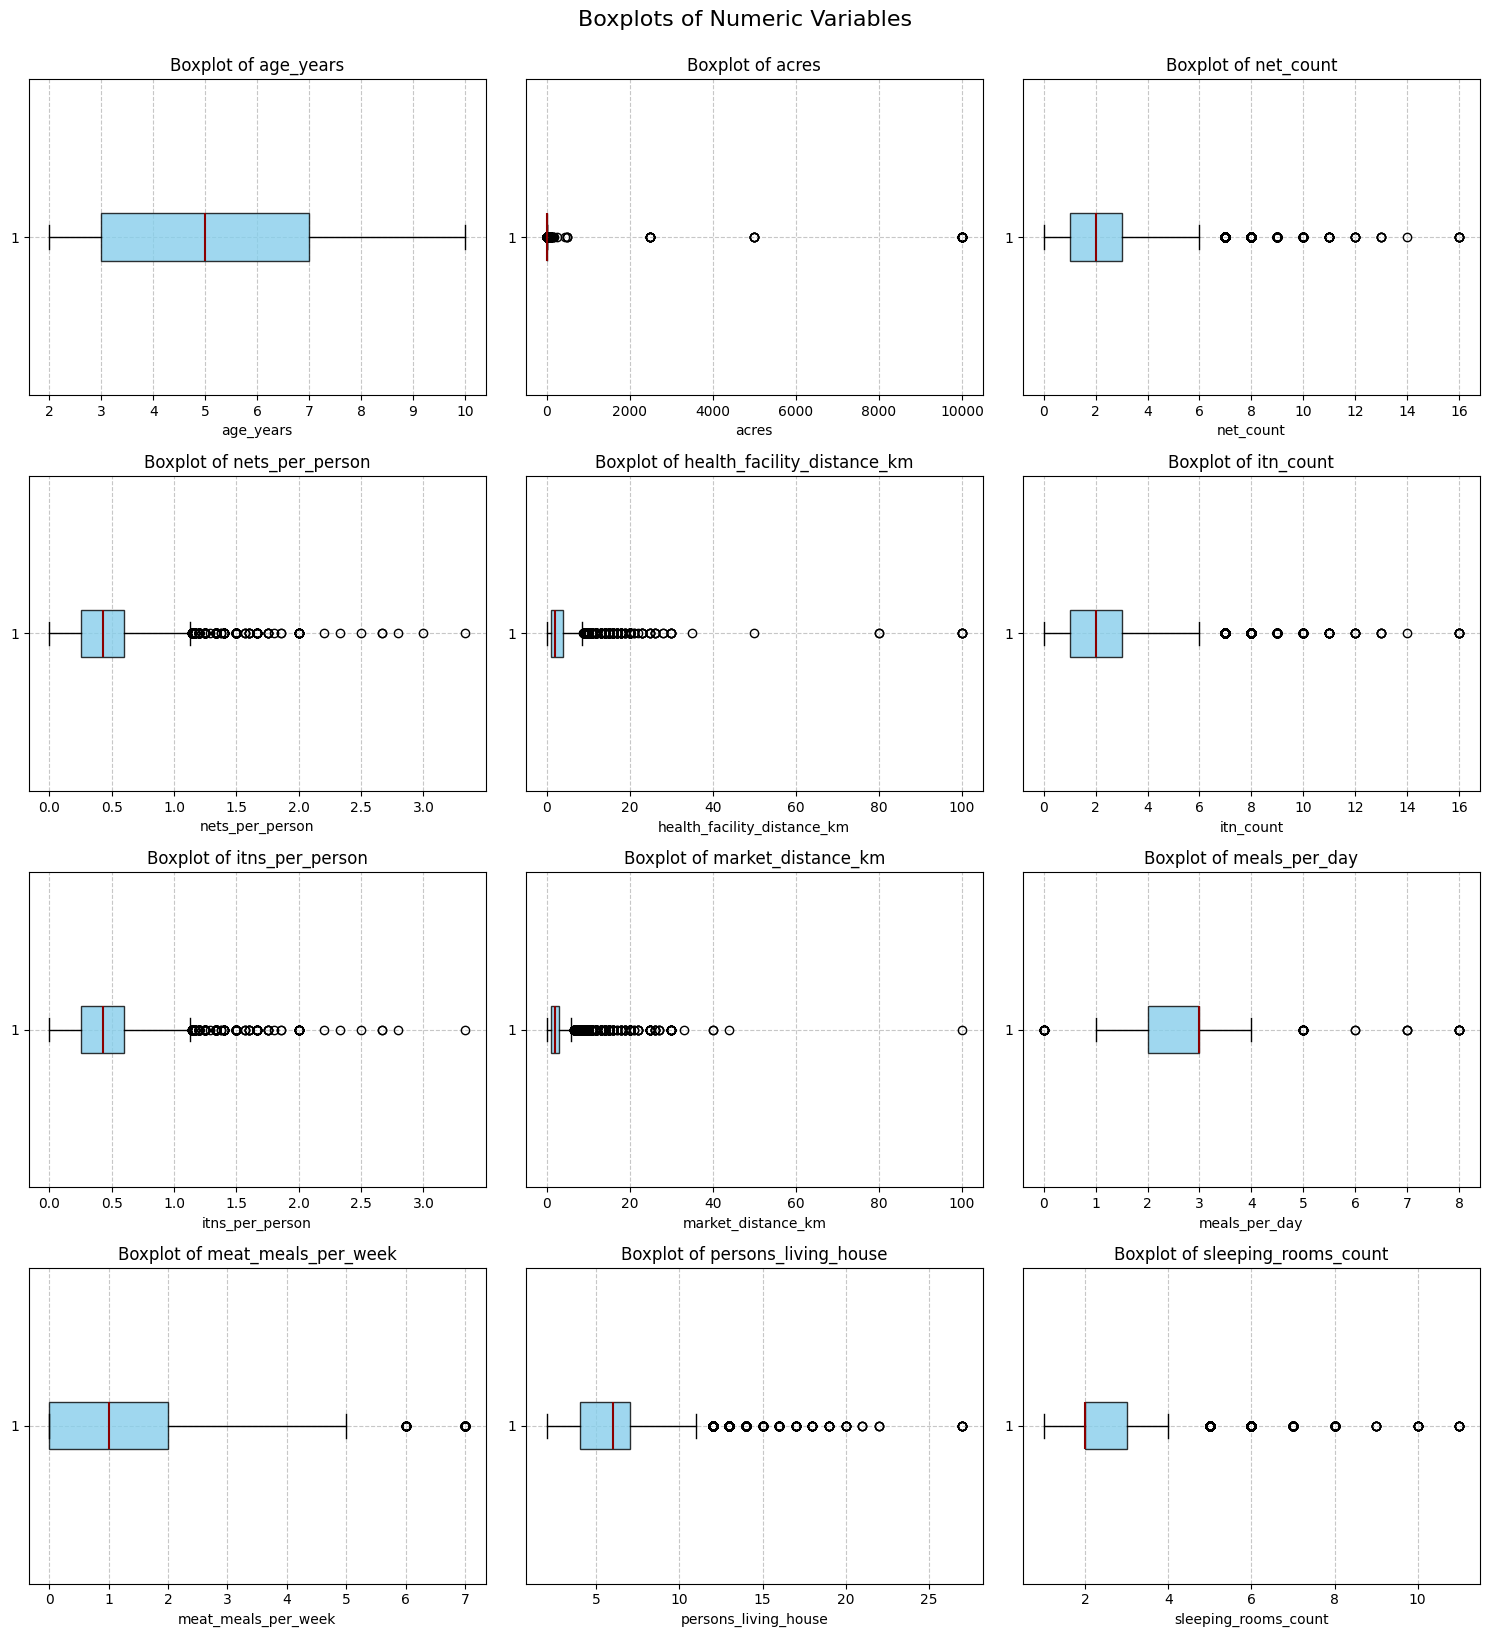

In [29]:
# View boxplots of numeric variables to see outliers
plot_numeric_boxplots(df_merged, numeric_vars)

In [30]:
# Remove these extreme outliers as they may bias the results.
df_merged = df_merged[
    (df_merged["acres"] <= 2000) &
    (df_merged["health_facility_distance_km"] <= 40) &
    (df_merged["market_distance_km"] <= 38)
]

##### Scale the numeric data

In [31]:
# Standardize numeric variables to have mean 0 and standard deviation 1
scaler = StandardScaler()
df_merged[numeric_vars] = scaler.fit_transform(df_merged[numeric_vars])

##### Perform a few sanity checks to make sure the data is clean

In [32]:
# First convert all columns to numeric
df_merged = df_merged.apply(pd.to_numeric)

In [33]:
# Make sure all columns are numeric
non_numeric_cols = df_merged.select_dtypes(exclude=["int8", "int32", "bool", "int64", "float64"]).columns.tolist()

if not non_numeric_cols:
    print("All columns are numeric.")
else:
    print("The following columns are NOT numeric:")
    print(non_numeric_cols)

All columns are numeric.


In [34]:
# Ensure the original categorical columns were dropped
remaining_categoricals = [col for col in categorical_vars if col in df_merged.columns]

if not remaining_categoricals:
    print("All original categorical variables have been dropped.")
else:
    print("The following original categorical variables are still present:")
    print(remaining_categoricals)


All original categorical variables have been dropped.


In [35]:
# Make a copy of the dataframe
df_clean = df_merged.copy(deep=True).reset_index(drop=True)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Columns: 108 entries, age_years to wall_material_onehot_Un-burned bricks with plaster or cement
dtypes: float64(12), int32(1), int64(19), int8(76)
memory usage: 9.5 MB


# Exploratory Data Analysis (EDA)

#### Class distribution

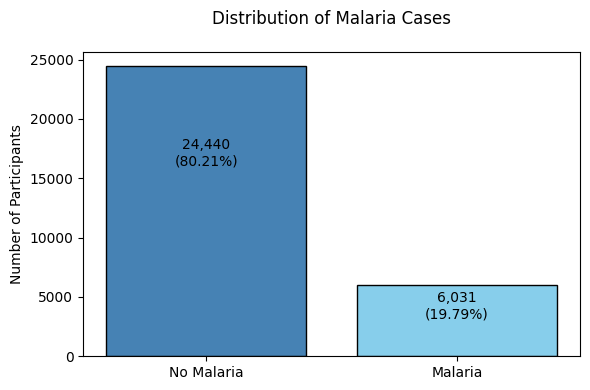

In [36]:
# Create a bar plot showing the distribution of malaria vs. no malaria cases

# Compute counts and percentages
malaria_counts = df_clean["malaria"].value_counts().sort_index()
malaria_percentages = (malaria_counts / malaria_counts.sum() * 100).round(2)

fig, ax = plt.subplots(figsize=(6, 4))

# Draw the bars
bars = ax.bar(
    x=["No Malaria", "Malaria"],
    height=malaria_counts.values,
    color=["#4682B4", "#87CEEB"],
    edgecolor='black'
)

# Annotate each bar
for i, bar in enumerate(bars):
    count = malaria_counts.values[i]
    percent = malaria_percentages.values[i]
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() * 0.7,  # position the text inside the bar
        f"{count:,}\n({percent}%)",
        ha='center',
        va='center',
        fontsize=10,
        color='black'
    )

# Add labels and title
ax.set_ylabel("Number of Participants")
ax.set_title("Distribution of Malaria Cases", pad=20)

# Adjust layout and save to file
plt.tight_layout()
plt.savefig('./figures/malaria_class_distribution.png')
plt.show()

#### Summary statistics for numeric variables

In [37]:
# Show basic descriptive statistics for numeric variables
summary_df = df_clean[numeric_vars].describe().T  # Transpose for better format

# Round to 3 decimal places
summary_df = summary_df.round(3)

# Display result
print(summary_df.to_string())

                               count  mean  std    min    25%    50%    75%     max
age_years                    30471.0   0.0  1.0 -1.382 -0.961 -0.119  0.722   1.985
acres                        30471.0  -0.0  1.0 -0.366 -0.237 -0.107  0.023  64.509
net_count                    30471.0   0.0  1.0 -1.507 -0.896 -0.284  0.327   8.277
nets_per_person              30471.0   0.0  1.0 -1.618 -0.688 -0.023  0.615  10.790
health_facility_distance_km  30471.0  -0.0  1.0 -1.146 -0.726 -0.307  0.532  13.539
itn_count                    30471.0   0.0  1.0 -1.469 -0.862 -0.255  0.352   8.243
itns_per_person              30471.0   0.0  1.0 -1.572 -0.650  0.009  0.641  10.721
market_distance_km           30471.0   0.0  1.0 -1.043 -0.630 -0.218  0.195  12.569
meals_per_day                30471.0   0.0  1.0 -4.274 -0.859  0.849  0.849   9.387
meat_meals_per_week          30471.0   0.0  1.0 -0.958 -0.958 -0.017  0.924   5.629
persons_living_house         30471.0  -0.0  1.0 -1.707 -0.846  0.014  0.444 

#### Plot histograms of numeric variables

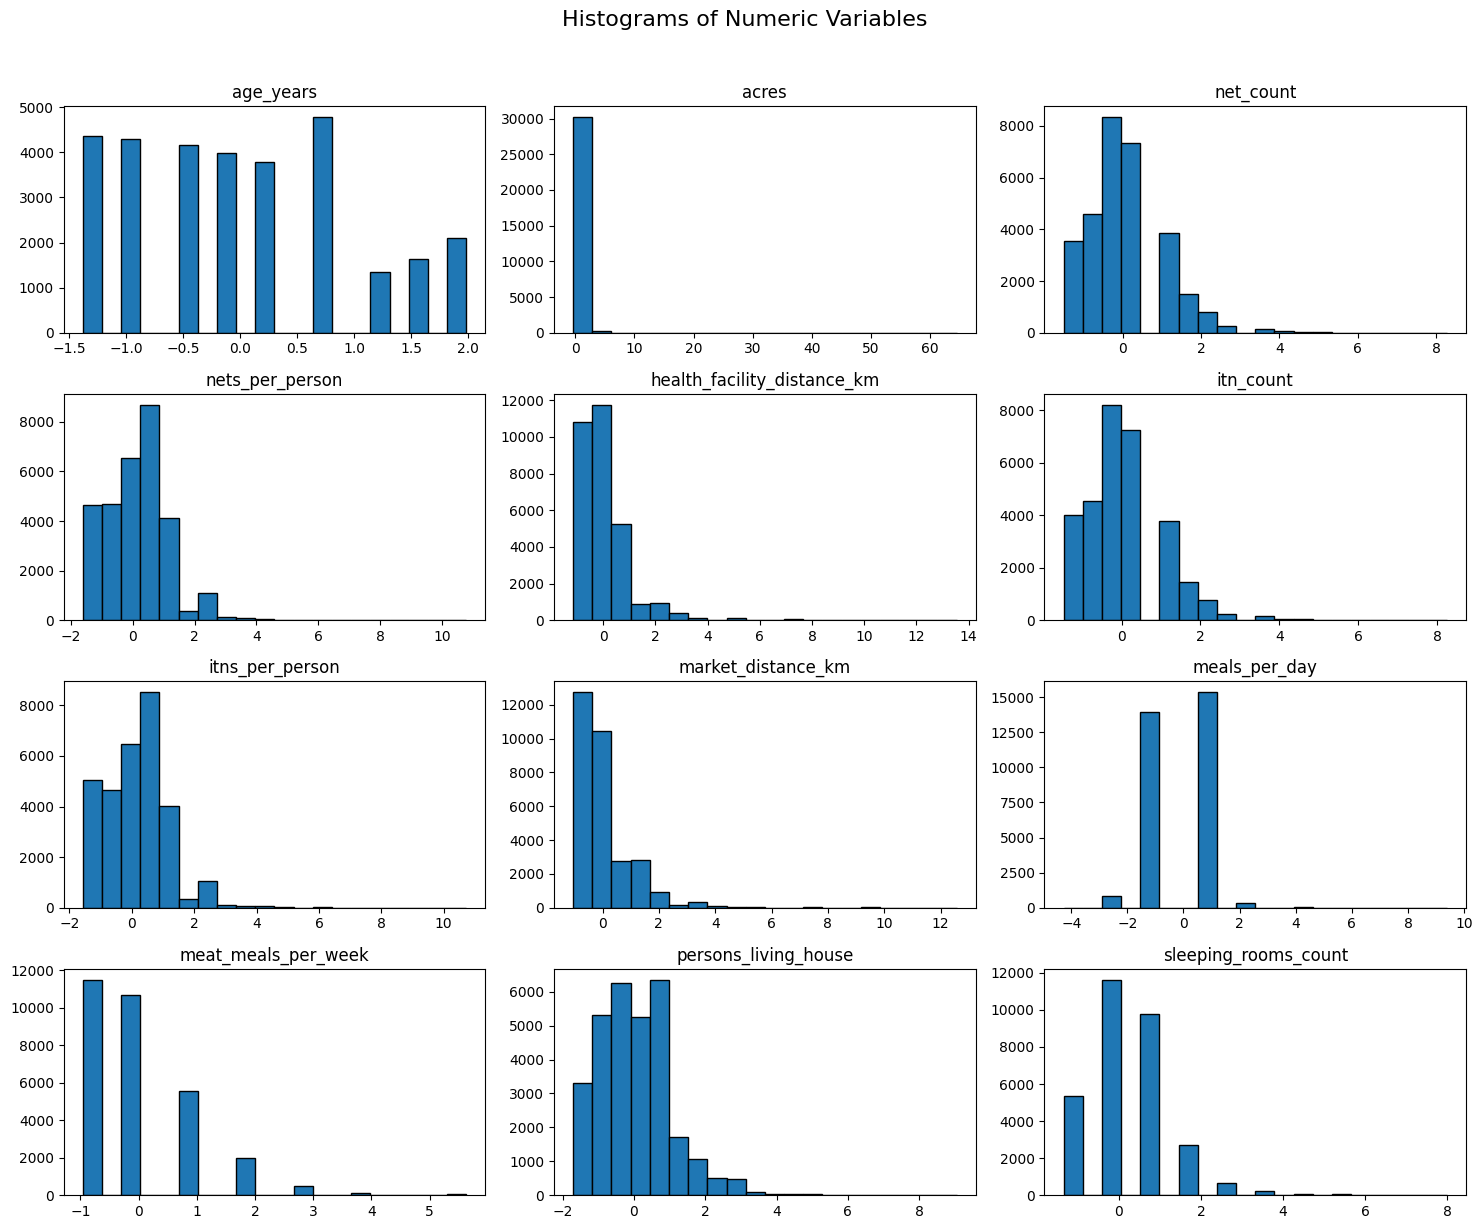

In [38]:
# Plot histograms of numeric variables
df_clean[numeric_vars].hist(
    figsize=(15, 12),
    bins=20,
    edgecolor='black',
    grid=False
)

plt.suptitle("Histograms of Numeric Variables", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

#### Find any highly correlated features

In [39]:
def find_highly_correlated_features(df, numeric_vars, threshold):
    """
    Identifies highly correlated feature pairs based on the given threshold.

    Parameters:
    df (DataFrame): The input Pandas DataFrame.
    numeric_vars (list): List of numeric column names.
    threshold (float): Correlation threshold to flag high correlation.

    Returns:
    list: List of (var1, var2, correlation) tuples for highly correlated pairs.
    """
    # Compute correlation matrix
    corr_matrix = df[numeric_vars].corr()

    # Store pairs
    high_corr_pairs = []

    # Check upper triangle of the correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > threshold:
                high_corr_pairs.append((col1, col2, round(corr_val, 3)))

    # Print the results
    if high_corr_pairs:
        print("Highly Correlated Pairs (|correlation| > {:.2f}):".format(threshold))
        for pair in high_corr_pairs:
            print(pair)
    else:
        print("No highly correlated pairs found.")

    return high_corr_pairs

In [40]:
# Show the highly correlated pairs
correlated_pairs = find_highly_correlated_features(df_clean, numeric_vars, threshold=0.75)

Highly Correlated Pairs (|correlation| > 0.75):
('net_count', 'nets_per_person', 0.756)
('net_count', 'itn_count', 0.984)
('nets_per_person', 'itns_per_person', 0.978)
('itn_count', 'itns_per_person', 0.766)


In [41]:
# Remove fields that are highly correlated as they are not necessary
columns_to_remove = ["nets_per_person", "itn_count", "itns_per_person"]
df_clean = df_clean.drop(columns=columns_to_remove, errors="ignore")

In [42]:
# Update the list of numeric variables
numeric_vars = [
    'age_years', 'acres', 'net_count', 'health_facility_distance_km', 'market_distance_km',
    'meals_per_day', 'meat_meals_per_week', 'persons_living_house', 'sleeping_rooms_count'
]

In [43]:
# Show the highly correlated pairs
correlated_pairs = find_highly_correlated_features(df_clean, numeric_vars, threshold=0.75)

No highly correlated pairs found.


#### Show a heatmap of numeric variables

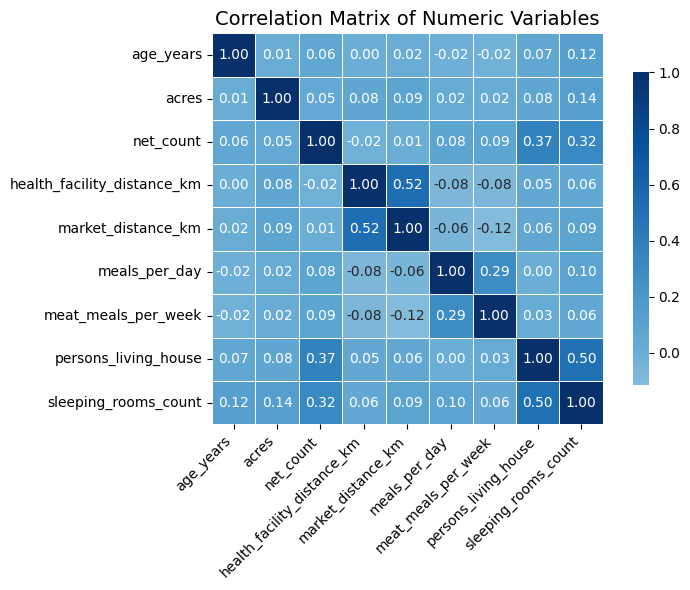

In [44]:
# Display a heatmap of numeric variables
# Compute correlation matrix directly from the DataFrame
corr_df = df_merged[numeric_vars].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_df,
    annot=True,           # Show correlation values
    fmt=".2f",            # Format numbers
    cmap="Blues",      # Color scheme
    center=0,             # Center the colormap at 0
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Matrix of Numeric Variables", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#### Save the final, clean dataset to CSV file

In [45]:
# Save the clean dataset
df_clean.to_csv("df_clean.csv", index=False)

# Housing Protection Score

The housing protection score is computed using a Random Forest model trained on housing-related features to predict malaria status. For each participant, this is defined as 

$$
\text{Housing Protection Score} = 1 - P(\text{malaria} \mid \text{housing features})
$$
indicating the model's predicted likelihood of not having malaria based on their housing conditions.


#### Create list of housing variables to use for the housing protection score

In [46]:
# Define the housing variables
housing_vars = ['windows_covered', 'sleeping_rooms_count', 'persons_living_house', 'net_count', 'bednet_used_last_night']

# And include all one-hot columns related to housing characteristics
housing_vars += [col for col in df_clean.columns if col.startswith((
    'floor_type_onehot_',
    'wall_material_onehot_',
    'eave_type_onehot_',
    'lighting_source_onehot_',
    'water_source_onehot_',
    'human_waste_facilities_onehot_'
))]

#### Train a Random Forest classifier

Train a Random Forest classifier to predict malaria status based on housing features, including structural characteristics (wall and floor type, etc.), utilities (water and lighting sources, etc.), and protective measures (e.g., bed net usage). The model is trained and evaluated using an 80/20 stratified split to preserve the class distribution.

The Random Forest model achieved an AUC-ROC of **0.774**, indicating good ability to distinguish between participants with and without malaria. This suggests that housing characteristics carry substantial predictive value for malaria risk.

In [47]:
# Train a Random Forest classifier 
# Set random seed for reproducibility
RANDOM_SEED = 99
np.random.seed(RANDOM_SEED)

# Define features and target
X = df_clean[housing_vars]
y = df_clean['malaria']

# Stratified train-test split to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)

# Train Random Forest classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_leaf=10,
    random_state=RANDOM_SEED,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Evaluate on test set
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

print(f"Test AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")

Test AUC-ROC: 0.7741


#### Compute the Housing Protection Score and Categorize Participants

This score represents the model's estimated probability that a household is *not* at risk of malaria based on its housing characteristics. Scores closer to 1 indicate higher predicted protection.

Participants are also grouped into **quintiles** using a rank-based method to account for potential ties:

- **Q1 (Lowest):** Least protective housing conditions
- **Q5 (Highest):** Most protective housing conditions

The distribution of the **housing protection score** shows that most participants had relatively high scores, with a **mean of 0.80** and **median of 0.84**, indicating that the majority of households were predicted to have a low malaria risk based on their housing characteristics. However, there is meaningful variation, with scores ranging from **0.33 to 0.98**, suggesting some households had considerably less protective housing conditions.

In [48]:
# Calculate Housing Protection Score for all participants
# Housing Protection Score = 1 - P(malaria|housing features)
housing_protection_scores = 1 - rf_model.predict_proba(X)[:, 1]
df_clean['housing_protection_score'] = housing_protection_scores

# Show distribution statistics of the housing protection score
print("\nHousing Protection Score Distribution:")
print(df_clean['housing_protection_score'].describe())

# Create quintiles using rank-based method to handle potential ties
df_clean['rank'] = df_clean['housing_protection_score'].rank(method='first')
df_clean['housing_protection_quintile'] = pd.qcut(
    df_clean['rank'], 
    q=5, 
    labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4', 'Q5 (Highest)']
)


Housing Protection Score Distribution:
count    30471.000000
mean         0.801718
std          0.134089
min          0.332451
25%          0.717394
50%          0.843155
75%          0.905794
max          0.983448
Name: housing_protection_score, dtype: float64


---

The correlation between the housing protection score and malaria status is **-0.469**, indicating a moderate negative relationship: as housing protection scores increase, the likelihood of testing positive for malaria decreases.

In [49]:
# Calculate correlation between housing protection score and malaria status
correlation = df_clean['housing_protection_score'].corr(df_clean['malaria'])
print(f"\nCorrelation between Housing Protection Score and Malaria: {correlation:.3f}")


Correlation between Housing Protection Score and Malaria: -0.469


---

#### Housing protection score and malaria status

The boxplot below shows a clear separation in housing protection scores between participants with and without malaria. Individuals who tested negative for malaria had consistently higher protection scores, with a higher median and tighter distribution. In contrast, those with malaria had lower and more variable scores, indicating weaker housing-related protection.

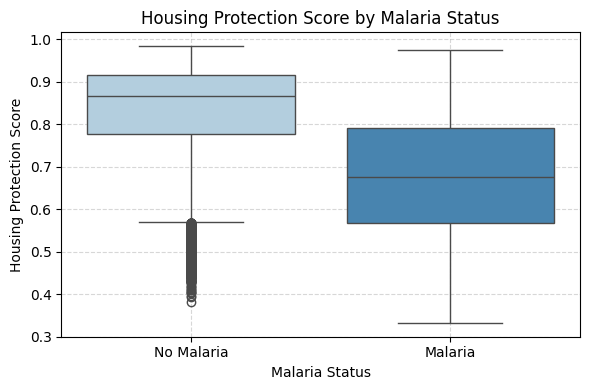

In [50]:
# Boxplot of Protection Score by Malaria Status
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df_clean,
    x='malaria',
    y='housing_protection_score',
    hue='malaria',
    palette=sns.color_palette('Blues', 2),
    legend=False
)

plt.xticks([0, 1], ['No Malaria', 'Malaria'])
plt.title('Housing Protection Score by Malaria Status')
plt.xlabel('Malaria Status')
plt.ylabel('Housing Protection Score')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('./figures/housing_protection_score_by_malaria_status.png', dpi=300, bbox_inches='tight')
plt.show()

#### Malaria prevalence by housing protection quintile

Malaria prevalence declined sharply across housing protection quintiles, from **52%** in the lowest quintile (Q1) to just **2%** in the highest quintile (Q5). This gradient indicates a strong inverse relationship between housing protection and malaria risk.

In [51]:
# Calculate malaria prevalence by housing protection quintile
quintile_malaria_rates = df_clean.groupby('housing_protection_quintile', observed=True)['malaria'].mean() * 100
print("\nMalaria Prevalence (%) by Housing Protection Quintile:")
print(quintile_malaria_rates)


Malaria Prevalence (%) by Housing Protection Quintile:
housing_protection_quintile
Q1 (Lowest)     51.205906
Q2              26.156876
Q3              13.587135
Q4               5.907450
Q5 (Highest)     2.100427
Name: malaria, dtype: float64


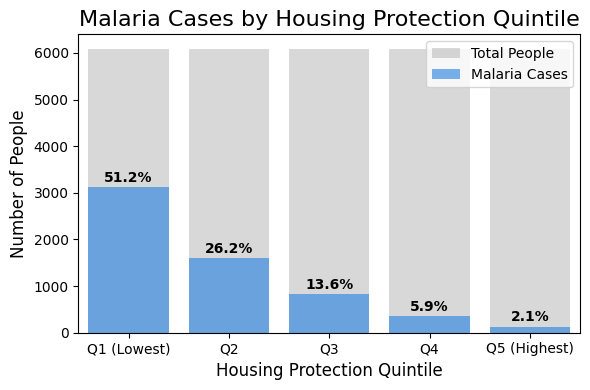

In [52]:
# Create a bar chart showing malaria cases by housing protection quintile
malaria_counts = df_clean.groupby('housing_protection_quintile', observed=True)['malaria'].sum().astype(int)
total_counts = df_clean.groupby('housing_protection_quintile', observed=True).size()

malaria_count_df = pd.DataFrame({
    'Quintile': malaria_counts.index,
    'Malaria Cases': malaria_counts.values,
    'Total People': total_counts.values
})

plt.figure(figsize=(6, 4))
# Plot total people in each quintile as background bars
sns.barplot(x='Quintile', y='Total People', data=malaria_count_df, alpha=0.3, color='gray', label='Total People')
# Plot malaria cases as foreground bars
sns.barplot(x='Quintile', y='Malaria Cases', data=malaria_count_df, alpha=0.6, color='#007FFF', label='Malaria Cases')

# Add percentage labels on top of each bar
for i, row in malaria_count_df.iterrows():
    percentage = (row['Malaria Cases'] / row['Total People']) * 100
    plt.text(i, row['Malaria Cases'] + 50, f"{percentage:.1f}%", 
             ha='center', va='bottom', color='black', fontweight='bold')

plt.title('Malaria Cases by Housing Protection Quintile', fontsize=16)
plt.xlabel('Housing Protection Quintile', fontsize=12)
plt.ylabel('Number of People', fontsize=12)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('./figures/malaria_by_protection_quintile.png', dpi=300, bbox_inches='tight')
plt.show()

### Individual Housing Predictors of Malaria Risk (Feature Importance)

The Random Forest model identified several housing-related factors as strong predictors of malaria risk. The most important feature by far was **use of a borehole as a water source**, followed by **access to a public or private tap**, **household size**, and **bed net ownership**.

The sharp drop-off in feature importance after the top few variables suggests that a small set of housing characteristics play a disproportionately large role in predicting malaria risk.

In [53]:
# Extract feature importances from the Random Forest model
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
})
feature_importances = feature_importances.sort_values('Importance', ascending=False)

print("\nTop 15 Housing Features for Malaria Prediction:")
print(feature_importances.head(15))


Top 15 Housing Features for Malaria Prediction:
                                              Feature  Importance
5                        water_source_onehot_Borehole    0.280900
18          water_source_onehot_Public or private tap    0.074196
2                                persons_living_house    0.073208
3                                           net_count    0.068208
43                 lighting_source_onehot_Electricity    0.046383
1                                sleeping_rooms_count    0.038307
4                              bednet_used_last_night    0.036518
59                 wall_material_onehot_Mud and poles    0.033552
16               water_source_onehot_Protected spring    0.025818
27               floor_type_onehot_Cement or concrete    0.024053
53        wall_material_onehot_Burned bricks with mud    0.023085
29                    floor_type_onehot_Earth or sand    0.021451
25                              eave_type_onehot_Open    0.019846
0                          

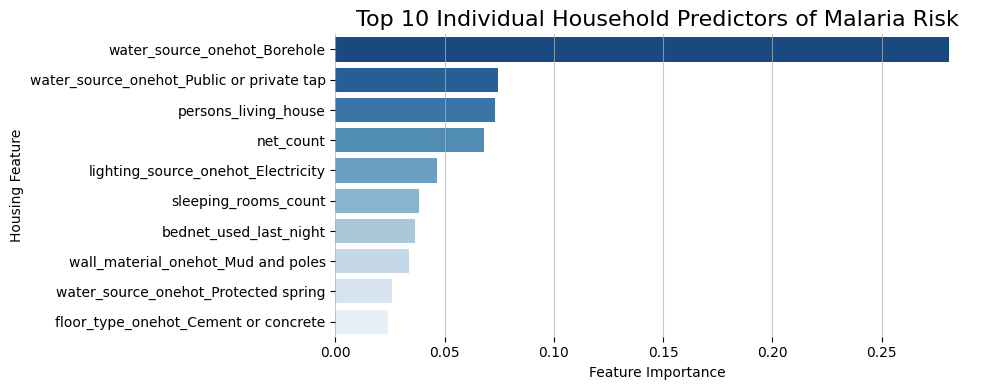

In [54]:
# Plot the individual housing characteristics feature importances
plt.figure(figsize=(10, 4))

top_features = feature_importances.head(10)

# Use a blue color palette
sns.barplot(x='Importance', y='Feature', data=top_features, palette="Blues_r", hue='Feature')

#  Title and labels
plt.title('Top 10 Individual Household Predictors of Malaria Risk', fontsize=16)
plt.xlabel('Feature Importance', fontsize=10) 
plt.ylabel('Housing Feature', fontsize=10)

plt.rcParams['ytick.labelsize'] = 10 

# Add gridlines
plt.grid(axis='x', linestyle='-', alpha=0.7)

# Remove spines
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig('./figures/top_housing_features.png', dpi=300, bbox_inches='tight')
plt.show()

### Aggregated Feature Importance by Housing Category

The aggregated feature importance scores show that **water source** was by far the most influential housing characteristic for predicting malaria, accounting for approximately **45%** of the total importance. This was followed by **wall material**, **lighting source**, and **household crowding (persons per house)**.

In [55]:
# Define the main categories and their corresponding columns
category_columns = {
    'windows_covered': ['windows_covered'],
    'sleeping_rooms_count': ['sleeping_rooms_count'],
    'persons_living_house': ['persons_living_house'],
    'net_count': ['net_count'],
    'bednet_used_last_night': ['bednet_used_last_night'],
    'floor_type': [col for col in df_clean.columns if col.startswith('floor_type_onehot_')],
    'wall_material': [col for col in df_clean.columns if col.startswith('wall_material_onehot_')],
    'eave_type': [col for col in df_clean.columns if col.startswith('eave_type_onehot_')],
    'lighting_source': [col for col in df_clean.columns if col.startswith('lighting_source_onehot_')],
    'water_source': [col for col in df_clean.columns if col.startswith('water_source_onehot_')],
    'human_waste_facilities': [col for col in df_clean.columns if col.startswith('human_waste_facilities_onehot_')]
}

# Get all housing variables
combined_housing_vars = []
for cols in category_columns.values():
    combined_housing_vars.extend(cols)

In [56]:
# Define features and target
X = df_clean[combined_housing_vars]
y = df_clean['malaria']

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_leaf=10,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

# Train the model
rf_model.fit(X_train, y_train)

# Evaluate on test set
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC-ROC: {auc_score:.4f}")

Test AUC-ROC: 0.7744


In [57]:
# Compute total importance per aggregated category
feature_importances = pd.Series(
    rf_model.feature_importances_,
    index=X.columns
)

category_importance = {}

for category, cols in category_columns.items():
    valid_cols = [col for col in cols if col in feature_importances.index]
    total_importance = feature_importances.loc[valid_cols].sum() if valid_cols else 0
    category_importance[category] = total_importance

category_importance = pd.Series(category_importance).sort_values(ascending=False)
print(category_importance)

water_source              0.452164
wall_material             0.086984
lighting_source           0.082775
persons_living_house      0.075739
net_count                 0.068385
floor_type                0.061291
human_waste_facilities    0.060412
sleeping_rooms_count      0.036570
bednet_used_last_night    0.036550
eave_type                 0.020206
windows_covered           0.018923
dtype: float64


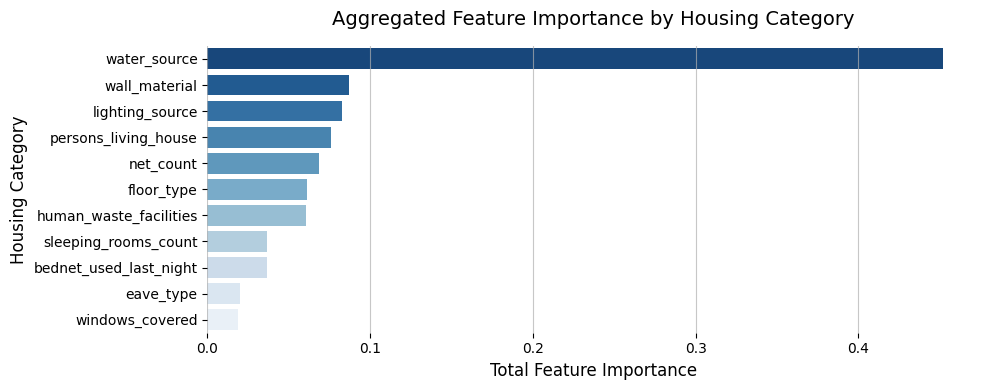

In [58]:
# Plot the features aggregated by category

# Convert to DataFrame
category_importance_df = category_importance.reset_index()
category_importance_df.columns = ['Category', 'Importance']

plt.figure(figsize=(10, 4))

# Use a blue color palette
sns.barplot(x='Importance', y='Category', data=category_importance_df, palette="Blues_r", hue='Category')

#  Title and labels
plt.title('Aggregated Feature Importance by Housing Category', fontsize=14, pad=15)
plt.xlabel('Total Feature Importance', fontsize=12)
plt.ylabel('Housing Category', fontsize=12)

plt.rcParams['ytick.labelsize'] = 12

# Add gridlines
plt.grid(axis='x', linestyle='-', alpha=0.7)

# Remove spines
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig('./figures/top_housing_features_grouped.png', dpi=300, bbox_inches='tight')
plt.show()

## Adjusted Odds Ratios for Housing Features

This section examines the association between key housing features and malaria risk using adjusted logistic regression. Composite indicators are constructed for protective housing characteristics, including finished floors, finished walls, closed eaves, and covered windows. The model controls for age and sex to account for potential confounding.



The adjusted logistic regression model revealed that several structural housing features were significantly associated with malaria risk, after controlling for age and sex.

- **Finished floors** were strongly protective, with an odds ratio (OR) of **0.45** (95% CI: 0.41–0.48, *p* < 0.001), indicating that participants living in homes with finished floors had approximately **55% lower odds** of malaria compared to those without.
  
- **Covered windows** were similarly protective (OR = **0.56**, 95% CI: 0.49–0.63, *p* < 0.001), suggesting that physical barriers to mosquito entry contribute meaningfully to malaria prevention.

- **Closed eaves** showed a modest but statistically significant protective effect (OR = **0.91**, 95% CI: 0.85–0.97, *p* = 0.002), consistent with prior evidence that sealing entry points can reduce indoor mosquito exposure.

- Interestingly, **finished walls** were associated with **higher odds of malaria** (OR = **1.55**, 95% CI: 1.45–1.67, *p* < 0.001). This counterintuitive finding may reflect coneconomic or environmental factors not captured in the model, or misclassification in how "finished" wall materials relate to ventilation and mosthis setting.

Overall, these findings reinforce the protective role of specific housing features in reducing malaria risk, particularly features that reduce mosquito entry and improve internal hous a report section.

In [59]:
# Construct composite housing feature variables

# Finished Floor: Bricks, cement, tiles, polished wood, or stones
df_clean["Finished_Floor"] = (
    (df_clean["floor_type_onehot_Bricks"] == 1)
    | (df_clean["floor_type_onehot_Cement or concrete"] == 1)
    | (df_clean["floor_type_onehot_Mosaic or tiles"] == 1)
    | (df_clean["floor_type_onehot_Parquet or polished wood"] == 1)
    | (df_clean["floor_type_onehot_Stones"] == 1)
).astype(int)

# Finished Walls: Includes plastered/cemented bricks, blocks, metal/iron sheets, timber, etc.
df_clean["Finished_Walls"] = (
    (df_clean["wall_material_onehot_Burned bricks with plaster or cement"] == 1)
    | (df_clean["wall_material_onehot_Cement blocks"] == 1)
    | (df_clean["wall_material_onehot_Iron sheets"] == 1)
    | (df_clean["wall_material_onehot_Metal sheets"] == 1)
    | (df_clean["wall_material_onehot_Mud, poles, and cement"] == 1)
    | (df_clean["wall_material_onehot_Mud, poles, and plaster"] == 1)
    | (df_clean["wall_material_onehot_Stone"] == 1)
    | (df_clean["wall_material_onehot_Stone, plaster, and cement"] == 1)
    | (df_clean["wall_material_onehot_Timber"] == 1)
    | (df_clean["wall_material_onehot_Un-burned bricks"] == 1)
    | (df_clean["wall_material_onehot_Un-burned bricks with plaster or cement"] == 1)
).astype(int)

# Closed Eaves: 1 if closed, 0 if open
df_clean["Closed_Eaves"] = (1 - df_clean["eave_type_onehot_Open"]).astype(int)

# Covered Windows: Already binary
df_clean["Covered_Windows"] = df_clean["windows_covered"].astype(int)


# Fit adjusted logistic regression model
# Define predictor variables and add constant
predictors = ["Finished_Floor", "Finished_Walls", "Closed_Eaves", "Covered_Windows", "age_years", "sex"]
X_adj = sm.add_constant(df_clean[predictors])
y = df_clean["malaria"]

# Fit logistic regression
model_adj = sm.Logit(y, X_adj).fit(disp=False)
summary_adj = model_adj.summary2().tables[1]


# Extract adjusted odds ratios and confidence intervals
features_to_extract = ["Finished_Floor", "Finished_Walls", "Closed_Eaves", "Covered_Windows"]
or_table = summary_adj.loc[features_to_extract].copy()

# Compute odds ratios and 95% confidence intervals
or_table["OR"] = np.exp(or_table["Coef."])
or_table["Lower CI"] = np.exp(or_table["Coef."] - 1.96 * or_table["Std.Err."])
or_table["Upper CI"] = np.exp(or_table["Coef."] + 1.96 * or_table["Std.Err."])
or_table["p-value"] = or_table["P>|z|"]

# Final formatting
or_table = or_table[["OR", "Lower CI", "Upper CI", "p-value"]]
or_table.reset_index(inplace=True)
or_table.rename(columns={"index": "Feature"}, inplace=True)

# Display the result
or_table

,Feature,OR,Lower CI,Upper CI,p-value
0,Finished_Floor,0.447874,0.414509,0.483924,6.175577e-92
1,Finished_Walls,1.551236,1.445157,1.665103,5.833985e-34
2,Closed_Eaves,0.908640,0.854492,0.966218,2.240974e-03
3,Covered_Windows,0.557203,0.494406,0.627976,9.131825e-22


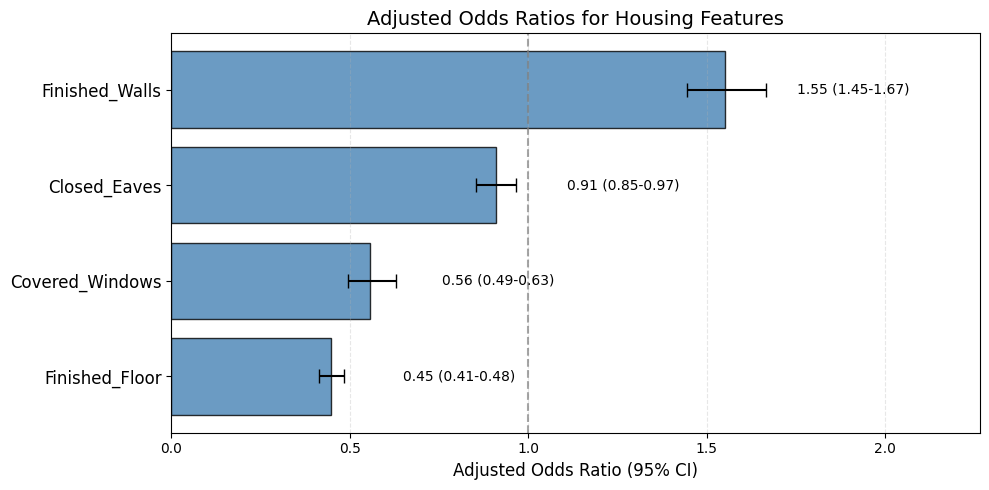

In [60]:
# Sort features by odds ratio for better visual structure
features = or_table["Feature"].tolist()
odds_ratios = or_table["OR"].values
ci_lower = or_table["Lower CI"].values
ci_upper = or_table["Upper CI"].values

sorted_indices = np.argsort(odds_ratios)
features_sorted = [features[i] for i in sorted_indices]
odds_sorted = odds_ratios[sorted_indices]
ci_lower_sorted = ci_lower[sorted_indices]
ci_upper_sorted = ci_upper[sorted_indices]

# Recalculate error bars
xerr_lower_sorted = odds_sorted - ci_lower_sorted
xerr_upper_sorted = ci_upper_sorted - odds_sorted

# Create plot
plt.figure(figsize=(10, 5))
y_pos = np.arange(len(features_sorted))

bars = plt.barh(
    y_pos,
    odds_sorted,
    xerr=[xerr_lower_sorted, xerr_upper_sorted],
    capsize=5,
    color='steelblue',
    edgecolor='black',
    alpha=0.8
)

# Vertical line at OR = 1
plt.axvline(x=1, color='gray', linestyle='--', alpha=0.7)

plt.yticks(y_pos, features_sorted, fontsize=12)

# Y-axis labels and title
plt.yticks(y_pos, features_sorted)
plt.xlabel("Adjusted Odds Ratio (95% CI)", fontsize=12)  # Adjust as needed
plt.title("Adjusted Odds Ratios for Housing Features", fontsize=14)  # Adjust as needed


# Gridlines
plt.grid(axis='x', linestyle='--', alpha=0.3)

# Add text labels slightly further right
for i, (or_val, lo, hi) in enumerate(zip(odds_sorted, ci_lower_sorted, ci_upper_sorted)):
    plt.text(
        or_val + 0.2,  # slight increase in offset
        i,
        f"{or_val:.2f} ({lo:.2f}-{hi:.2f})",
        va='center',
        ha='left',
        fontsize=10,
        color='black'
    )

# Adjust axis limits for better spacing
plt.xlim(0, max(ci_upper_sorted) + 0.6)
plt.tight_layout()
plt.savefig('./figures/housing_features_odds_ratios.png', dpi=300, bbox_inches='tight')
plt.show()

## Socioeconomic Status (SES) Index

A Socioeconomic Status (SES) Index was constructed to explore the relationship between household socioeconomic factors and malaria prevalence. Principal Component Analysis (PCA) was applied to a set of SES-related variables, including household assets (e.g., ownership of a bed, chair, television), access to utilities (e.g., electricity, internet devices), financial indicators (e.g., bank account ownership), transportation means (e.g., bicycle, motorcycle ownership), and other relevant factors such as distance to markets and health facilities. The first principal component was extracted to serve as the SES Index, with its sign inverted to ensure higher values correspond to higher socioeconomic status. Households were also categorized into SES quintiles, ranging from Q1 (Lowest) to Q5 (Highest), based on their SES Index scores.

Analysis of malaria prevalence across quintiles revealed a negative correlation between socioeconomic status and malaria prevalence. The findings suggest that higher socioeconomic status is associated with a reduced prevalence of malaria, highlighting the potential impact of socioeconomic factors on malaria risk.

In [61]:
# SES variables
ses_vars = [
    'has_bed', 'has_chair', 'has_clock', 'has_cupboard', 'has_sofa', 'has_table', 'has_tv', 'has_watch',
    'has_radio', 'has_electricity', 'has_internet_device', 'has_mobile_phone',
    'bank_account', 'has_bicycle', 'has_motorcycle', 'market_distance_km', 'has_cassette_player',
    'meals_per_day', 'meat_meals_per_week', 'acres', 'health_facility_distance_km'
]

# Include one-hot columns related to SES
ses_vars += [col for col in df_clean.columns if col.startswith((
    'transit_to_health_facility_onehot_',
    'food_insecurity_weekly_onehot_'
))]

In [62]:
# Extract SES data
ses_data = df_clean[ses_vars].dropna()

# Run PCA and retain the first component
pca = PCA(n_components=1)
ses_index = pca.fit_transform(ses_data).flatten()

# Create a new DataFrame to match the PCA output back to the original
df_ses = df_clean.loc[ses_data.index].copy()
# Flip the sign of the PCA index
df_ses['SES_Index'] = -ses_index

# Recreate SES quintiles with the corrected index direction
df_ses['SES_Quintile'] = pd.qcut(df_ses['SES_Index'], 5, labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4', 'Q5 (Highest)'])

# Recalculate malaria prevalence by SES quintile
malaria_by_quintile = df_ses.groupby('SES_Quintile', observed=False)['malaria'].mean().reset_index()
malaria_by_quintile.columns = ['SES Quintile', 'Malaria Prevalence']
malaria_by_quintile

,SES Quintile,Malaria Prevalence
0,Q1 (Lowest),0.254593
1,Q2,0.237486
2,Q3,0.204628
3,Q4,0.178700
4,Q5 (Highest),0.114211


In [63]:
# Save the dataset to file
df_ses.to_csv("df_ses.csv", index=False)

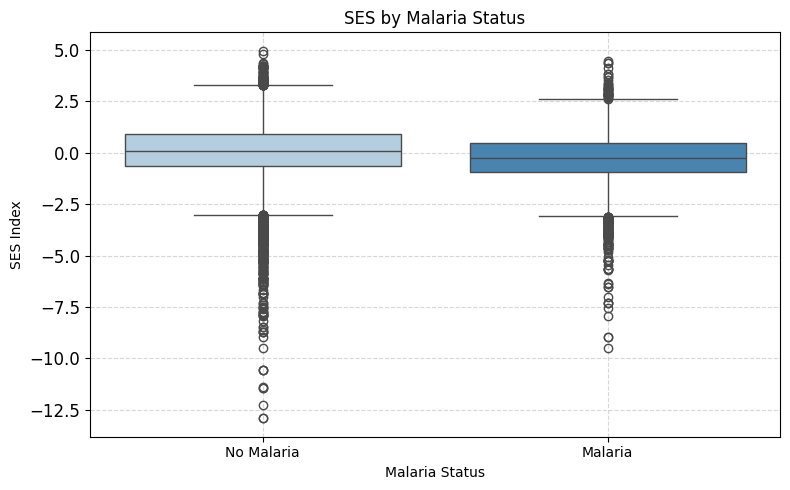

In [64]:
# Boxplot of SES index by Malaria Status
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_ses,
    x='malaria',
    y='SES_Index',
    hue='malaria',
    palette='Blues',
    legend=False
)

plt.xticks([0, 1], ['No Malaria', 'Malaria'])
plt.title('SES by Malaria Status')
plt.xlabel('Malaria Status')
plt.ylabel('SES Index')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

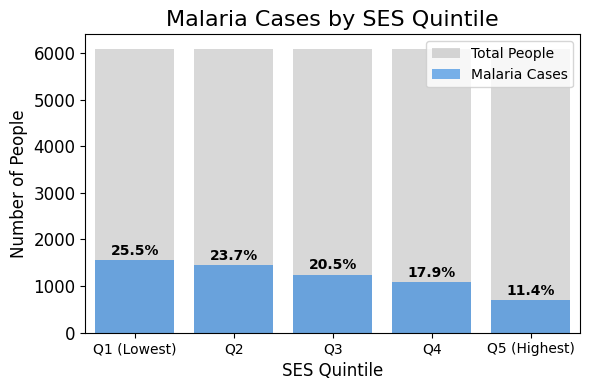

In [65]:
# Plot Malaria Cases by SES Quintile
malaria_counts = df_ses.groupby('SES_Quintile', observed=True)['malaria'].sum().astype(int)
total_counts = df_ses.groupby('SES_Quintile', observed=True).size()

malaria_count_df = pd.DataFrame({
    'Quintile': malaria_counts.index,
    'Malaria Cases': malaria_counts.values,
    'Total People': total_counts.values
})

plt.figure(figsize=(6, 4))
# Plot total people in each quintile as background bars
sns.barplot(x='Quintile', y='Total People', data=malaria_count_df, alpha=0.3, color='gray', label='Total People')
# Plot malaria cases as foreground bars
sns.barplot(x='Quintile', y='Malaria Cases', data=malaria_count_df, alpha=0.6, color='#007FFF', label='Malaria Cases')

# Add percentage labels on top of each bar
for i, row in malaria_count_df.iterrows():
    percentage = (row['Malaria Cases'] / row['Total People']) * 100
    plt.text(i, row['Malaria Cases'] + 50, f"{percentage:.1f}%", 
             ha='center', va='bottom', color='black', fontweight='bold')

plt.title('Malaria Cases by SES Quintile', fontsize=16)
plt.xlabel('SES Quintile', fontsize=12)
plt.ylabel('Number of People', fontsize=12)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('./figures/malaria_by_ses_quintile.png', dpi=300, bbox_inches='tight')
plt.show()

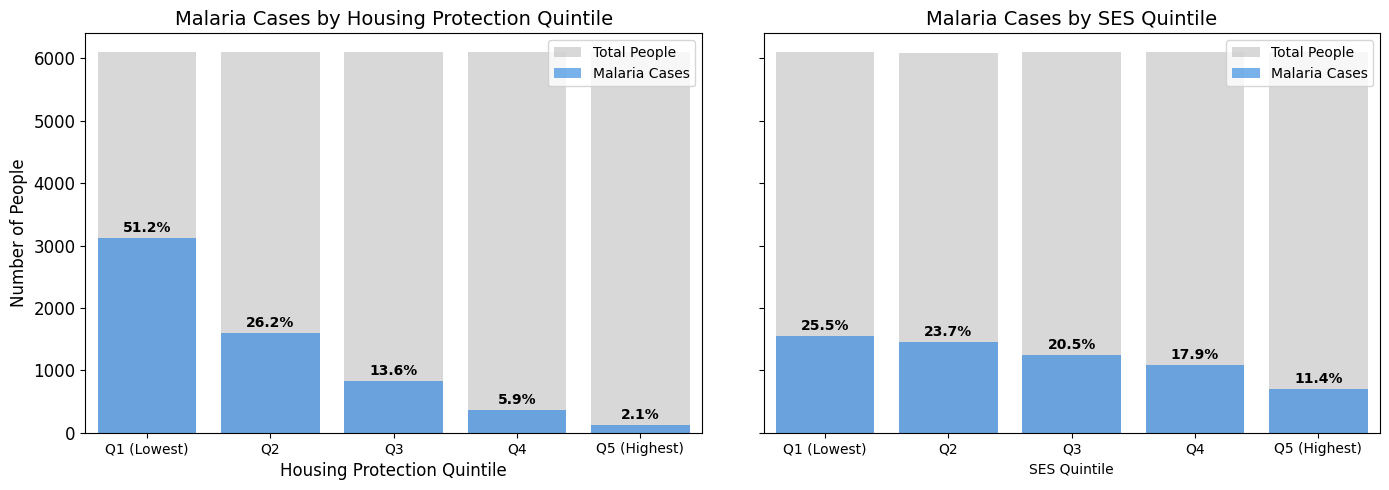

In [66]:
# Plot Malaria Cases by SES Quintile and malaria cases by housing protection quintile side by side
# First plot Housing Protection
malaria_counts_hp = df_clean.groupby('housing_protection_quintile', observed=True)['malaria'].sum().astype(int)
total_counts_hp = df_clean.groupby('housing_protection_quintile', observed=True).size()

malaria_count_df_hp = pd.DataFrame({
    'Quintile': malaria_counts_hp.index,
    'Malaria Cases': malaria_counts_hp.values,
    'Total People': total_counts_hp.values
})

# Second plot SES
malaria_counts_ses = df_ses.groupby('SES_Quintile', observed=True)['malaria'].sum().astype(int)
total_counts_ses = df_ses.groupby('SES_Quintile', observed=True).size()

malaria_count_df_ses = pd.DataFrame({
    'Quintile': malaria_counts_ses.index,
    'Malaria Cases': malaria_counts_ses.values,
    'Total People': total_counts_ses.values
})

# Create 1x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot Housing Protection
sns.barplot(x='Quintile', y='Total People', data=malaria_count_df_hp, alpha=0.3, color='gray', ax=axes[0], label='Total People')
sns.barplot(x='Quintile', y='Malaria Cases', data=malaria_count_df_hp, alpha=0.6, color='#007FFF', ax=axes[0], label='Malaria Cases')

for i, row in malaria_count_df_hp.iterrows():
    pct = (row['Malaria Cases'] / row['Total People']) * 100
    axes[0].text(i, row['Malaria Cases'] + 50, f"{pct:.1f}%", ha='center', va='bottom', fontweight='bold')

axes[0].set_title('Malaria Cases by Housing Protection Quintile', fontsize=14)
axes[0].set_xlabel('Housing Protection Quintile', fontsize=12)
axes[0].set_ylabel('Number of People', fontsize=12)
axes[0].legend(loc='upper right')

# Plot SES
sns.barplot(x='Quintile', y='Total People', data=malaria_count_df_ses, alpha=0.3, color='gray', ax=axes[1], label='Total People')
sns.barplot(x='Quintile', y='Malaria Cases', data=malaria_count_df_ses, alpha=0.6, color='#007FFF', ax=axes[1], label='Malaria Cases')

for i, row in malaria_count_df_ses.iterrows():
    pct = (row['Malaria Cases'] / row['Total People']) * 100
    axes[1].text(i, row['Malaria Cases'] + 50, f"{pct:.1f}%", ha='center', va='bottom', fontweight='bold')

axes[1].set_title('Malaria Cases by SES Quintile', fontsize=14)
axes[1].set_xlabel('SES Quintile')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.subplots_adjust(wspace=0.1)  # Increase horizontal space between the two plots

plt.savefig('./figures/malaria_by_quintiles_side_by_side.png', dpi=300, bbox_inches='tight')
plt.show()

## ​Logistic Regression Analysis of Socioeconomic Status (SES) Quintiles and Malaria Prevalence

A logistic regression analysis was conducted to assess the association between socioeconomic status (SES) quintiles and malaria prevalence, both unadjusted and adjusted for covariates.

**Creating SES Quintile Dummy Variables** - Dummy variables are generated for SES quintiles using `pd.get_dummies()`, with the lowest quintile (Q1) as the reference category. This setup enables comparisons between higher quintiles (Q2 to Q5) and Q1 in the regression models.

**Unadjusted Logistic Regression Model** - An initial logistic regression model evaluates the unadjusted relationship between SES quintiles and malaria prevalence, including only the SES quintile dummies as predictors.

**Adjusted Logistic Regression Model** - A subsequent model adjusts for age, sex, and housing protection score to control for potential confounders.

**Interpretation:**

- **Unadjusted Model:** In the unadjusted analysis, individuals in the highest SES quintile (Q5) have 62% lower odds of malaria compared to those in the lowest quintile (Q1), as indicated by an OR of 0.38. Similarly, those in the fourth quintile (Q4) have 36% lower odds (OR = 0.64).

- **Adjusted Model:** After adjusting for age, sex, and housing protection score, the protective effect of higher SES remains significant, though slightly reduced. For instance, individuals in Q5 have 30% lower odds of malaria compared to Q1 (OR = 0.70), suggesting that while SES is independently associated with malaria prevalence, part of its effect may be mediated by housing conditions and demographic factors.

In [67]:
# Create SES quintile dummies (Q1 as reference)
ses_dummies = pd.get_dummies(df_ses['SES_Quintile'], drop_first=True)

# Ensure your target is numeric and aligned with predictors
y = df_ses['malaria'].astype(float)

# Create dummies for SES quintile (drop Q1 as reference)
ses_dummies = pd.get_dummies(df_ses['SES_Quintile'], drop_first=True)
X_unadj = sm.add_constant(ses_dummies).astype(float)

# Fit unadjusted model
model_unadj = sm.Logit(y, X_unadj).fit(disp=0)
summary_unadj = model_unadj.summary2().tables[1]

# Add covariates and ensure everything is float
X_adj = pd.concat([ses_dummies, df_ses[['age_years', 'sex', 'housing_protection_score']]], axis=1)
X_adj = sm.add_constant(X_adj).astype(float)

# Fit adjusted model
model_adj = sm.Logit(y, X_adj).fit(disp=0)

summary_adj = model_adj.summary2().tables[1]

# Extract ORs and confidence intervals
def extract_or_ci(summary, labels):
    ors = np.exp(summary['Coef.'])
    lower = np.exp(summary['Coef.'] - 1.96 * summary['Std.Err.'])
    upper = np.exp(summary['Coef.'] + 1.96 * summary['Std.Err.'])
    formatted = []
    for label in labels:
        formatted.append(f"{ors[label]:.2f} ({lower[label]:.2f}-{upper[label]:.2f})")
    return formatted

# Prepare row labels in order
quintile_labels = ['Q2', 'Q3', 'Q4', 'Q5 (Highest)']
row_labels = ['Low', 'Middle', 'High', 'Highest']

# Extract formatted ORs
unadj_or_ci = extract_or_ci(summary_unadj, quintile_labels)
adj_or_ci = extract_or_ci(summary_adj, quintile_labels)

# Create table
table_data = pd.DataFrame({
    'SES Quintile': ['Lowest'] + row_labels,
    'Unadjusted OR (95% CI)': ['Reference'] + unadj_or_ci,
    'Adjusted OR (95% CI)': ['Reference'] + adj_or_ci
})
table_data

,SES Quintile,Unadjusted OR (95% CI),Adjusted OR (95% CI)
0,Lowest,Reference,Reference
1,Low,0.91 (0.84-0.99),0.95 (0.87-1.05)
2,Middle,0.75 (0.69-0.82),0.78 (0.71-0.86)
3,High,0.64 (0.58-0.70),0.79 (0.71-0.87)
4,Highest,0.38 (0.34-0.42),0.70 (0.63-0.79)


# Mediation Analysis

To better understand the relationship between housing conditions, socioeconomic status (SES), and malaria risk, a mediation analysis was conducted. Specifically, this analysis evaluates whether SES mediates the effect of housing protection on malaria, or whether housing mediates the relationship between SES and malaria.  

The analysis estimates the direct effect, indirect (mediated) effect, and total effect using bootstrap confidence intervals to assess statistical significance. This approach helps clarify whether the protective impact of housing is partially explained by household socioeconomic status - or whether the influence of SES on malaria operates in part through housing quality.

#### Relationship Between Housing Protection Score and SES Index

The scatterplot below shows the relationship between `housing_protection_score` (x-axis) and `SES_Index` (y-axis), with a fitted linear regression line in red.

- There appears to be a slightly positive relationship between SES and housing protection score.
- Households with higher SES tend to have higher protection scores, but the relationship is weak (as shown by the small slope).
- This supports the idea that SES is related to housing quality, though other factors may also influence protection independently of wealth.

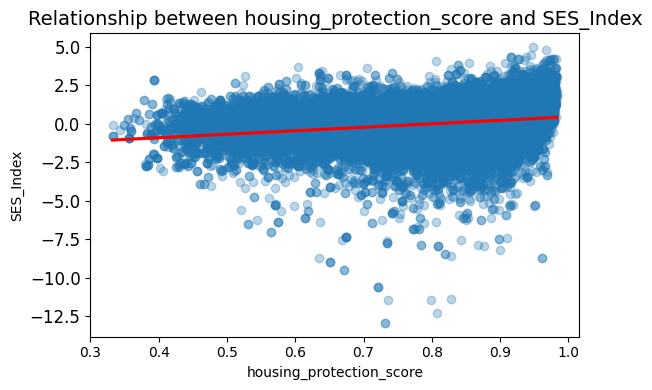

In [68]:
# Create a plot to show the relationship between housing_protection_score and SES_Index
plt.figure(figsize=(6, 4))
sns.regplot(
    x='housing_protection_score',
    y='SES_Index',
    data=df_ses,
    scatter_kws={'alpha': 0.3},
    line_kws={'color': 'red'}
)

# Add labels and title
plt.title('Relationship between housing_protection_score and SES_Index', fontsize=14)
plt.xlabel('housing_protection_score')
plt.ylabel('SES_Index')

# Save the plot and show it
plt.tight_layout()
plt.savefig('./figures/relationship_housing_prot_score_ses.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [69]:
# Functions for mediations anlaysis
def calculate_mediation_effects(df, X_var, M_var, Y_var, n_bootstrap=5000, random_state=99):
    """
    Performs a complete mediation analysis with bootstrapping.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The dataset containing the variables
    X_var : str
        Name of the independent variable/exposure
    M_var : str
        Name of the mediator variable
    Y_var : str
        Name of the dependent variable/outcome
    n_bootstrap : int, default=5000
        Number of bootstrap samples for CI estimation
    random_state : int, default=99
        Random seed for reproducibility
    
    Returns:
    --------
    dict
        Dictionary containing the results of the mediation analysis
    """
    
    # Create a dataframe
    df_complete = df[[X_var, M_var, Y_var]].dropna()
    
    # Standardize housing score and ses index
    df_complete[f"{X_var}_z"] = stats.zscore(df_complete[X_var])
    df_complete[f"{M_var}_z"] = stats.zscore(df_complete[M_var])
    
    # Step 1: Test the total effect (c path) - X → Y
    X_c = sm.add_constant(df_complete[f"{X_var}_z"])
    model_c = Logit(df_complete[Y_var], X_c)
    result_c = model_c.fit(disp=0)
    c_coef = result_c.params.iloc[1]
    c_p = result_c.pvalues.iloc[1]
    c_odds = np.exp(c_coef)
    
    # Step 2: Test the effect of X on M (a path)
    X_a = sm.add_constant(df_complete[f"{X_var}_z"])
    model_a = sm.OLS(df_complete[f"{M_var}_z"], X_a)
    result_a = model_a.fit()
    a_coef = result_a.params.iloc[1]
    a_p = result_a.pvalues.iloc[1]
    
    # Step 3: Test the effect of M on Y, controlling for X (b path)
    X_b = sm.add_constant(df_complete[[f"{X_var}_z", f"{M_var}_z"]])
    model_b = Logit(df_complete[Y_var], X_b)
    result_b = model_b.fit(disp=0)
    b_coef = result_b.params.iloc[2]  # coefficient for M
    b_p = result_b.pvalues.iloc[2]
    b_odds = np.exp(b_coef)
    
    # Get the direct effect (c' path)
    cprime_coef = result_b.params.iloc[1]  # coefficient for X
    cprime_p = result_b.pvalues.iloc[1]
    cprime_odds = np.exp(cprime_coef)
    
    # Calculate indirect effect (a*b)
    indirect_effect = a_coef * b_coef
    
    # Calculate proportion mediated
    if c_coef != 0:
        prop_mediated = indirect_effect / c_coef
    else:
        prop_mediated = 0
    
    # Bootstrap confidence intervals for indirect effect
    np.random.seed(random_state)
    bootstrap_indirect = []
    
    for i in range(n_bootstrap):
        # Sample with replacement
        boot_sample = resample(df_complete, replace=True)
        
        # Path a
        X_a_boot = sm.add_constant(boot_sample[f"{X_var}_z"])
        model_a_boot = sm.OLS(boot_sample[f"{M_var}_z"], X_a_boot)
        result_a_boot = model_a_boot.fit()
        a_boot = result_a_boot.params.iloc[1]
        
        # Path b
        X_b_boot = sm.add_constant(boot_sample[[f"{X_var}_z", f"{M_var}_z"]])
        try:
            model_b_boot = Logit(boot_sample[Y_var], X_b_boot)
            result_b_boot = model_b_boot.fit(disp=0)
            b_boot = result_b_boot.params.iloc[2]
            
            # Store indirect effect
            bootstrap_indirect.append(a_boot * b_boot)
        except:
            # Skip iteration if convergence issues
            continue
    
    # Calculate 95% confidence intervals
    ci_lower = np.percentile(bootstrap_indirect, 2.5)
    ci_upper = np.percentile(bootstrap_indirect, 97.5)
    
    # Determine mediation type
    if c_p < 0.05:  # Significant total effect
        if a_p < 0.05 and b_p < 0.05:  # Both paths significant
            if ci_lower > 0 or ci_upper < 0:  # CI doesn't include 0
                if cprime_p < 0.05:
                    mediation_type = "Partial mediation"
                else:
                    mediation_type = "Full mediation"
            else:
                mediation_type = "No significant mediation (CI includes 0)"
        else:
            mediation_type = "No mediation (path a or b not significant)"
    else:
        if a_p < 0.05 and b_p < 0.05 and (ci_lower > 0 or ci_upper < 0):
            mediation_type = "Indirect-only mediation (no direct effect but significant indirect effect)"
        else:
            mediation_type = "No mediation (no total effect)"
    
    # Calculate Sobel test (for comparison)
    se_a = result_a.bse.iloc[1]
    se_b = result_b.bse.iloc[2]
    sobel_se = np.sqrt(b_coef**2 * se_a**2 + a_coef**2 * se_b**2)
    sobel_z = indirect_effect / sobel_se
    sobel_p = 2 * (1 - stats.norm.cdf(abs(sobel_z)))
    
    # Results dictionary
    results = {
        "total_effect": {
            "coefficient": c_coef,
            "p_value": c_p,
            "odds_ratio": c_odds
        },
        "path_a": {
            "coefficient": a_coef,
            "p_value": a_p
        },
        "path_b": {
            "coefficient": b_coef,
            "p_value": b_p,
            "odds_ratio": b_odds
        },
        "direct_effect": {
            "coefficient": cprime_coef,
            "p_value": cprime_p,
            "odds_ratio": cprime_odds
        },
        "indirect_effect": {
            "coefficient": indirect_effect,
            "bootstrap_ci": (ci_lower, ci_upper),
            "sobel_test": {
                "z_value": sobel_z,
                "p_value": sobel_p
            }
        },
        "proportion_mediated": prop_mediated,
        "mediation_type": mediation_type,
        "n_bootstrap": len(bootstrap_indirect)
    }
    
    return results

def create_path_diagram(results, X_name, M_name, Y_name, filename="./figures/mediation_path_diagram.png"):
    """
    Creates a path diagram visualization for the mediation analysis.
    
    Parameters:
    -----------
    results : dict
        Results from the mediation analysis
    X_name : str
        Name of independent variable
    M_name : str
        Name of mediator variable
    Y_name : str
        Name of dependent variable
    filename : str, default="mediation_path_diagram.png"
        Filename to save the diagram
    """
    # Extract coefficients and p-values
    a_coef = results['path_a']['coefficient']
    a_p = results['path_a']['p_value']
    b_coef = results['path_b']['coefficient']
    b_p = results['path_b']['p_value']
    c_coef = results['total_effect']['coefficient']
    c_p = results['total_effect']['p_value']
    cprime_coef = results['direct_effect']['coefficient']
    cprime_p = results['direct_effect']['p_value']
    
    # Create figure
    plt.figure(figsize=(8, 6))
    
    # Draw paths
    # Path a: X -> M
    plt.annotate("", xy=(0.5, 0.7), xytext=(0.2, 0.5),
                arrowprops=dict(arrowstyle="->", color="black" if a_p < 0.05 else "gray", lw=2))
    # Path b: M -> Y
    plt.annotate("", xy=(0.8, 0.5), xytext=(0.5, 0.7),
                arrowprops=dict(arrowstyle="->", color="black" if b_p < 0.05 else "gray", lw=2))
    # Path c': X -> Y direct
    plt.annotate("", xy=(0.8, 0.5), xytext=(0.2, 0.5),
                arrowprops=dict(arrowstyle="->", color="black" if cprime_p < 0.05 else "gray", 
                              linestyle="solid", lw=2))
    # Path c: X -> Y total (dashed)
    plt.annotate("", xy=(0.8, 0.4), xytext=(0.2, 0.4),
                arrowprops=dict(arrowstyle="->", color="black" if c_p < 0.05 else "gray",
                              linestyle="dashed", lw=2))
    
    # Add nodes
    plt.scatter([0.2, 0.5, 0.8], [0.5, 0.7, 0.5], s=3000, 
               facecolors=['lightblue', 'lightgreen', 'lightcoral'],
               edgecolors='black', zorder=10)
    
    # Add labels
    # X label - Housing Protection Score on three lines, above and left of blue circle
    if X_name == 'housing_protection_score':
        X_name = 'Housing\nProtection\nScore'  # Replace with formatted name on multiple lines
    plt.text(0.19, 0.62, X_name, ha='right', va='center', fontsize=14, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2', edgecolor='none'))
    
    # Middle (SES_Index) - lowered slightly from top of green circle
    plt.text(0.5, 0.8, M_name, ha='center', va='center', fontsize=14, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2', edgecolor='none'))
    
    # Y label - above the right circle
    plt.text(0.8, 0.62, Y_name, ha='center', va='center', fontsize=14, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2', edgecolor='none'))
    
    # Add coefficients
    plt.text(0.35, 0.65, f"a = {a_coef:.3f}" + ("*" if a_p < 0.05 else ""), 
            ha='center', va='center', fontsize=12)
    plt.text(0.65, 0.65, f"b = {b_coef:.3f}" + ("*" if b_p < 0.05 else ""), 
            ha='center', va='center', fontsize=12)
    plt.text(0.5, 0.53, f"c' = {cprime_coef:.3f}" + ("*" if cprime_p < 0.05 else ""), 
            ha='center', va='center', fontsize=12, 
            bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3'))
    plt.text(0.5, 0.35, f"c = {c_coef:.3f}" + ("*" if c_p < 0.05 else "") + " (total effect)", 
            ha='center', va='center', fontsize=12)
    
    # Add indirect effect
    indirect = results['indirect_effect']['coefficient']
    ci_lower, ci_upper = results['indirect_effect']['bootstrap_ci']
    significant = (ci_lower > 0) or (ci_upper < 0)  # CI doesn't contain 0
    
    plt.text(0.5, 0.25, f"Indirect effect (a×b) = {indirect:.3f}" + ("*" if significant else ""), 
            ha='center', va='center', fontsize=12,
            bbox=dict(facecolor='lightyellow', alpha=0.8, boxstyle='round,pad=0.3'))
    plt.text(0.5, 0.18, f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]", 
            ha='center', va='center', fontsize=10)
    
    # Add proportion mediated
    prop = results['proportion_mediated']
    plt.text(0.5, 0.1, f"Proportion mediated: {prop:.1%}", 
            ha='center', va='center', fontsize=12,
            bbox=dict(facecolor='lightyellow', alpha=0.8, boxstyle='round,pad=0.3'))
    
    # Finish plot
    plt.text(0.5, 0.9, "Mediation Analysis", ha='center', va='center', 
            fontsize=16, fontweight='bold')
    plt.text(0.5, 0.85, f"Type: {results['mediation_type']}", ha='center', va='center',
            fontsize=14, fontstyle='italic')
    
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.axis('off')
    
    # Add legend for significance
    plt.text(0.02, 0.02, "* p < 0.05", fontsize=10)
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    return filename

def mediation_analysis_pipeline(df, X_var, M_var, Y_var, n_bootstrap=5000):
    """
    Runs the complete mediation workflow: estimates effects, creates path diagram, and prints summary.
    
    Parameters:
        df: DataFrame containing all variables
        X_var: Exposure/independent variable
        M_var: Mediator
        Y_var: Outcome
        n_bootstrap: Number of bootstrap samples (default 5000)
    
    Returns:
        Tuple of (results dictionary, path diagram filename)
    """

    # Run the mediation analysis
    results = calculate_mediation_effects(df, X_var, M_var, Y_var, n_bootstrap)
    
    # Generate visualizations
    path_diagram = create_path_diagram(results, X_var, M_var, Y_var)
    
    # Print summary report
    print("\n" + "="*50)
    print("MEDIATION ANALYSIS SUMMARY REPORT")
    print("="*50)
    print(f"Independent variable (X): {X_var}")
    print(f"Mediator variable (M): {M_var}")
    print(f"Dependent variable (Y): {Y_var}")
    print(f"Sample size: {len(df[[X_var, M_var, Y_var]].dropna())}")
    print("-"*50)
    
    return results, path_diagram

### Interpretation of Mediation Analysis Results

The mediation analysis examined whether socioeconomic status (SES) acts as a mediator in the relationship between housing protection and malaria risk. The results indicate **partial mediation**:

- Housing protection score was significantly associated with both SES (β = 0.230, *p* < 0.001) and malaria (total effect OR = 0.314, *p* < 0.001).
- SES was also independently associated with malaria** (OR = 0.899, *p* < 0.001), even when controlling for housing.
- The **indirect effect** of housing on malaria through SES was statistically significant but small (effect = –0.025, 95% CI [–0.032, –0.017]), accounting for just **2.1%** of the total effect.

These findings suggest that while housing and SES are related, most of the protective effect of housing on malaria is not explained by SES, indicating that housing conditions influence malaria risk through pathways beyond just socioeconomic position.

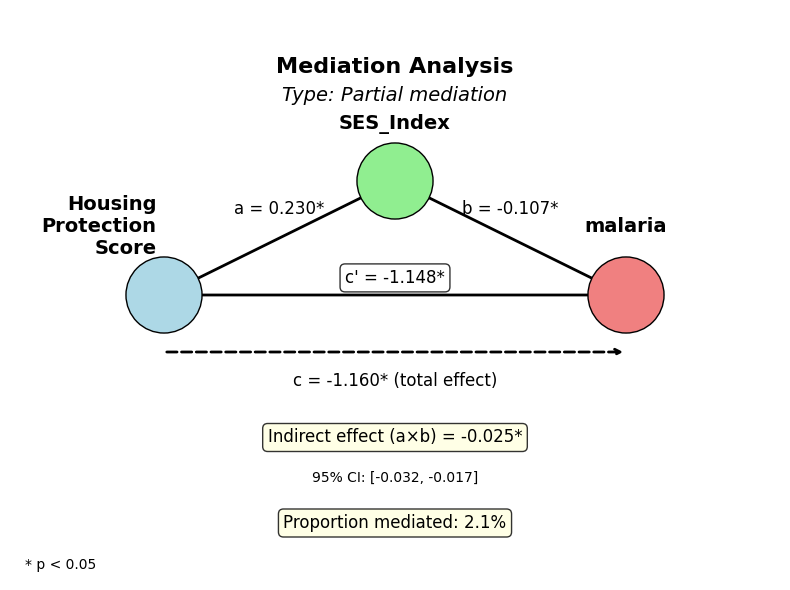


MEDIATION ANALYSIS SUMMARY REPORT
Independent variable (X): housing_protection_score
Mediator variable (M): SES_Index
Dependent variable (Y): malaria
Sample size: 30471
--------------------------------------------------

KEY FINDINGS:
1. Total effect of housing protection on malaria: OR = 0.314, p < 0.001
2. Effect of housing protection on SES: β = 0.230, p < 0.001
3. Effect of SES on malaria (controlling for housing): OR = 0.899, p < 0.001
4. Direct effect of housing on malaria (controlling for SES): OR = 0.317, p < 0.001
5. Indirect effect (through SES): -0.025, 95% CI [-0.032, -0.017]
6. Proportion of effect mediated: 2.1%
7. Mediation type: Partial mediation


In [70]:
# Run the mediation analysis
results, path_diagram = mediation_analysis_pipeline(
    df_ses, 
    'housing_protection_score', 
    'SES_Index', 
    'malaria',
    n_bootstrap=5000
)

# And display the findings
print("\nKEY FINDINGS:")

# Total effect
odds_ratio = results['total_effect']['odds_ratio']
p_value = results['total_effect']['p_value']
p_display = "p < 0.001" if p_value < 0.001 else f"p = {p_value:.4f}"
print(f"1. Total effect of housing protection on malaria: OR = {odds_ratio:.3f}, {p_display}")

# Path A effect
coef = results['path_a']['coefficient']
p_value = results['path_a']['p_value']
p_display = "p < 0.001" if p_value < 0.001 else f"p = {p_value:.4f}"
print(f"2. Effect of housing protection on SES: β = {coef:.3f}, {p_display}")

# Path B effect
odds_ratio = results['path_b']['odds_ratio']
p_value = results['path_b']['p_value']
p_display = "p < 0.001" if p_value < 0.001 else f"p = {p_value:.4f}"
print(f"3. Effect of SES on malaria (controlling for housing): OR = {odds_ratio:.3f}, {p_display}")

# Direct effect
odds_ratio = results['direct_effect']['odds_ratio']
p_value = results['direct_effect']['p_value']
p_display = "p < 0.001" if p_value < 0.001 else f"p = {p_value:.4f}"
print(f"4. Direct effect of housing on malaria (controlling for SES): OR = {odds_ratio:.3f}, {p_display}")

# Other results
print(f"5. Indirect effect (through SES): {results['indirect_effect']['coefficient']:.3f}, 95% CI [{results['indirect_effect']['bootstrap_ci'][0]:.3f}, {results['indirect_effect']['bootstrap_ci'][1]:.3f}]")
print(f"6. Proportion of effect mediated: {results['proportion_mediated']:.1%}")
print(f"7. Mediation type: {results['mediation_type']}")

# Summary statistics

This section creates summary statistics for the dataset

In [71]:
# Load the dataset
df = pd.read_csv("df_ses.csv")

# Unscale age_years using provided original mean and std
original_mean = 5.283968
original_std = 2.378111
df['age_years'] = df['age_years'] * original_std + original_mean

# Derived binary variables
df["female"] = (df["sex"] == 2).astype(int)
df["open_eaves"] = (df["Closed_Eaves"] == 0).astype(int)

# Label mapping for quintiles
quintile_map = {
    'Q1': 'Q1 (Lowest)',
    'Q5': 'Q5 (Highest)'
}
df['SES_Quintile'] = df['SES_Quintile'].replace(quintile_map)
df['housing_protection_quintile'] = df['housing_protection_quintile'].replace(quintile_map)

# Split by malaria status
malaria_pos = df[df["malaria"] == 1]
malaria_neg = df[df["malaria"] == 0]

# Helper functions
def binary_summary(var):
    pos_count = malaria_pos[var].sum()
    pos_pct = 100 * pos_count / len(malaria_pos)
    neg_count = malaria_neg[var].sum()
    neg_pct = 100 * neg_count / len(malaria_neg)
    contingency = pd.crosstab(df[var], df["malaria"])
    chi2, p, _, _ = chi2_contingency(contingency)
    return f"{int(pos_count):,} ({pos_pct:.1f}%)", f"{int(neg_count):,} ({neg_pct:.1f}%)", f"$<${0.001}" if p < 0.001 else f"{p:.3f}"

def continuous_summary(var):
    pos_mean, pos_sd = malaria_pos[var].mean(), malaria_pos[var].std()
    neg_mean, neg_sd = malaria_neg[var].mean(), malaria_neg[var].std()
    _, p = ttest_ind(malaria_pos[var], malaria_neg[var], nan_policy='omit')
    return f"{pos_mean:.1f} ({pos_sd:.1f})", f"{neg_mean:.1f} ({neg_sd:.1f})", f"$<${0.001}" if p < 0.001 else f"{p:.3f}"

# Build main summary stats
summary_data = [
    ("Age in years, mean (SD)", *continuous_summary("age_years")),
    ("Female sex, n (%)", *binary_summary("female")),
    ("Finished wall material", *binary_summary("Finished_Walls")),
    ("Finished floor material", *binary_summary("Finished_Floor")),
    ("Open eaves", *binary_summary("open_eaves")),
    ("Covered windows", *binary_summary("Covered_Windows")),
    ("Electricity", *binary_summary("has_electricity")),
    ("Mobile phone", *binary_summary("has_mobile_phone")),
    ("Radio", *binary_summary("has_radio")),
    ("Television", *binary_summary("has_tv")),
    ("Bicycle", *binary_summary("has_bicycle")),
    ("Bank account", *binary_summary("bank_account")),
    ("Slept under Bednet previous night", *binary_summary("bednet_used_last_night")),
]

summary_df = pd.DataFrame(summary_data, columns=["Characteristic", "Malaria Positive", "Malaria Negative", "p-value"])

# SES quintile summary
ses_order = ['Q1 (Lowest)', 'Q2', 'Q3', 'Q4', 'Q5 (Highest)']
ses_data = []
for q in ses_order:
    pos = (malaria_pos["SES_Quintile"] == q).sum()
    pos_pct = 100 * pos / len(malaria_pos)
    neg = (malaria_neg["SES_Quintile"] == q).sum()
    neg_pct = 100 * neg / len(malaria_neg)
    ses_data.append((q, f"{pos:,} ({pos_pct:.1f}%)", f"{neg:,} ({neg_pct:.1f}%)"))

chi2, p_ses, _, _ = chi2_contingency(pd.crosstab(df["SES_Quintile"], df["malaria"]))
p_ses_str = "$<$0.001" if p_ses < 0.001 else f"{p_ses:.3f}"

# Housing protection quintile summary
hpq_order = ['Q1 (Lowest)', 'Q2', 'Q3', 'Q4', 'Q5 (Highest)']
hpq_data = []
for q in hpq_order:
    pos = (malaria_pos["housing_protection_quintile"] == q).sum()
    pos_pct = 100 * pos / len(malaria_pos)
    neg = (malaria_neg["housing_protection_quintile"] == q).sum()
    neg_pct = 100 * neg / len(malaria_neg)
    hpq_data.append((q, f"{pos:,} ({pos_pct:.1f}%)", f"{neg:,} ({neg_pct:.1f}%)"))

chi2, p_hpq, _, _ = chi2_contingency(pd.crosstab(df["housing_protection_quintile"], df["malaria"]))
p_hpq_str = "$<$0.001" if p_hpq < 0.001 else f"{p_hpq:.3f}"

# Output in LaTeX format
summary_df, ses_data, p_ses_str, hpq_data, p_hpq_str

(                       Characteristic Malaria Positive Malaria Negative  \
 0             Age in years, mean (SD)        5.4 (2.4)        5.3 (2.4)   
 1                   Female sex, n (%)    2,962 (49.1%)   12,722 (52.1%)   
 2              Finished wall material    2,911 (48.3%)   12,085 (49.4%)   
 3             Finished floor material    1,673 (27.7%)    9,707 (39.7%)   
 4                          Open eaves    1,964 (32.6%)    7,119 (29.1%)   
 5                     Covered windows    5,602 (92.9%)   23,507 (96.2%)   
 6                         Electricity       376 (6.2%)    4,606 (18.8%)   
 7                        Mobile phone    4,842 (80.3%)   20,938 (85.7%)   
 8                               Radio    3,601 (59.7%)   17,064 (69.8%)   
 9                          Television       386 (6.4%)    4,087 (16.7%)   
 10                            Bicycle    2,480 (41.1%)    6,442 (26.4%)   
 11                       Bank account      673 (11.2%)    5,324 (21.8%)   
 12  Slept u

# Machine Learning

### Machine Learning Workflow for Malaria Prediction

- **Feature Importance Analysis:**  
  Random Forest and Gradient Boosting classifiers are trained to estimate model-based feature importances. Permutation importance is also computed on held-out test data to obtain model-agnostic estimates. The top predictors are identified by aggregating normalized importance scores across models.

- **Class Imbalance Handling:**  
  Synthetic Minority Over-sampling Technique (SMOTE) is applied to balance the target classes prior to model training.

- **Model Development and Tuning:**  
  Four classifiers are trained and evaluated: Logistic Regression, Random Forest, Gradient Boosting, and XGBoost. Hyperparameter tuning is performed using stratified 10-fold cross-validation with `GridSearchCV`, optimizing for ROC AUC.

- **Model Evaluation:**  
  A broad range of performance metrics is computed, including AUC, PR-AUC, accuracy, precision, recall, F1 score, specificity, balanced accuracy, geometric mean (G-Mean), and Matthews Correlation Coefficient (MCC).

- **Visualization and Reporting:**  
  ROC and precision-recall curves are plotted for all models. Feature importance plots and performance metric comparison charts are generated. Final evaluation results are compiled into a formatted table for interpretation.

### Feature Importance

In [72]:
"""
Feature Importance Analysis for Malaria Prediction
-------------------------------------------------
"""
# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")

def load_and_prepare_data(file_path):
    """Load and prepare the dataset for feature importance analysis."""
    print(f"Loading data from {file_path}...")
    df = pd.read_csv(file_path)
    
    # Split features and target
    X = df.drop('malaria', axis=1)
    y = df['malaria']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=99, stratify=y
    )
    
    return X_train, X_test, y_train, y_test, X.columns

def random_forest_importance(X_train, y_train, feature_names):
    """Extract feature importance from Random Forest."""
    print("Training Random Forest for feature importance...")
    rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=99)
    rf.fit(X_train, y_train)
    
    # Get feature importances
    importances = rf.feature_importances_
    indices = np.argsort(importances)[-20:]  # Top 20 features
    
    # Create DataFrame
    rf_importance_df = pd.DataFrame({
        'Feature': [feature_names[i] for i in indices],
        'Importance': [float(importances[i]) for i in indices],  # Ensure float type
        'Model': ['Random Forest'] * len(indices)
    })
    
    return rf_importance_df, rf

def gradient_boosting_importance(X_train, y_train, feature_names):
    """Extract feature importance from Gradient Boosting."""
    print("Training Gradient Boosting for feature importance...")
    gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=99)
    gb.fit(X_train, y_train)
    
    # Get feature importances
    importances = gb.feature_importances_
    indices = np.argsort(importances)[-20:]  # Top 20 features
    
    # Create DataFrame
    gb_importance_df = pd.DataFrame({
        'Feature': [feature_names[i] for i in indices],
        'Importance': [float(importances[i]) for i in indices],  # Ensure float type
        'Model': ['Gradient Boosting'] * len(indices)
    })
    
    return gb_importance_df, gb

def permutation_feature_importance(model, X_test, y_test, feature_names, model_name):
    """Calculate permutation importance for a model."""
    print(f"Calculating permutation importance for {model_name}...")
    
    # Calculate permutation importance
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=99)
    
    # Get indices of top features
    indices = np.argsort(perm_importance.importances_mean)[-20:]  # Top 20 features
    
    # Create DataFrame
    perm_importance_df = pd.DataFrame({
        'Feature': [feature_names[i] for i in indices],
        'Importance': [float(perm_importance.importances_mean[i]) for i in indices],  # Ensure float type
        'Model': [f'{model_name} (Permutation)'] * len(indices)
    })
    
    return perm_importance_df

def plot_feature_importance(importance_df, title, filename):
    """Plot feature importance."""
    if importance_df.empty:
        print(f"Skipping plot '{title}' because DataFrame is empty")
        return
        
    plt.figure(figsize=(12, 10))
    
    # Create horizontal bar plot using matplotlib
    features = importance_df['Feature'].values
    importances = importance_df['Importance'].values
    models = importance_df['Model'].values
    
    # Get unique models
    unique_models = list(importance_df['Model'].unique())
    model_colors = plt.cm.viridis(np.linspace(0, 1, len(unique_models)))
    
    # Create a dict to map models to colors
    color_map = dict(zip(unique_models, model_colors))
    
    # Sort the data by importance for better visualization
    # Create a dictionary to store the sorted data for each model
    model_data = {}
    for model in unique_models:
        model_mask = models == model
        model_features = features[model_mask]
        model_importances = importances[model_mask]
        
        # Sort by importance
        sorted_indices = np.argsort(model_importances)
        model_data[model] = {
            'features': model_features[sorted_indices],
            'importances': model_importances[sorted_indices]
        }
    
    # Plot bars for each model
    y_positions = {}
    y_labels = []
    y_ticks = []
    
    current_y = 0
    for i, model in enumerate(unique_models):
        data = model_data[model]
        num_features = len(data['features'])
        
        # Calculate y positions for this model
        positions = np.arange(current_y, current_y + num_features)
        y_positions[model] = positions
        
        # Update y_labels and y_ticks
        y_labels.extend(data['features'])
        y_ticks.extend(positions)
        
        # Plot bars
        plt.barh(positions, data['importances'], color=color_map[model], label=model)
        
        # Update current_y for the next model
        current_y += num_features + 1  # Add 1 for spacing between models
    
    # Add legend
    plt.legend(loc='lower right')
    
    # Set y-axis labels
    plt.yticks(y_ticks, y_labels)
    
    plt.xlabel('Importance', fontsize=12)
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()


def identify_key_predictors(importance_dfs):
    """Identify and rank key predictors across all models."""
    # Filter out empty DataFrames
    importance_dfs = [df for df in importance_dfs if not df.empty]
    
    # if not importance_dfs:
    #     print("No importance DataFrames available to identify key predictors")
    #     return pd.DataFrame(columns=['Feature', 'Normalized_Importance'])
    
    # Combine all importance dataframes
    all_importances = pd.concat(importance_dfs)
    
    # Normalize importances within each model to make them comparable
    all_importances['Normalized_Importance'] = 0.0  # Initialize
    
    for model in all_importances['Model'].unique():
        model_mask = all_importances['Model'] == model
        max_value = all_importances.loc[model_mask, 'Importance'].max()
        if max_value > 0:  # Avoid division by zero
            all_importances.loc[model_mask, 'Normalized_Importance'] = (
                all_importances.loc[model_mask, 'Importance'] / max_value
            )
    
    # Calculate average normalized importance for each feature
    feature_rankings = all_importances.groupby('Feature')['Normalized_Importance'].mean().reset_index()
    feature_rankings = feature_rankings.sort_values('Normalized_Importance', ascending=False).head(20)
    
    return feature_rankings

In [73]:
# Load and prepare data
X_train, X_test, y_train, y_test, feature_names = load_and_prepare_data('df_clean.csv')

# Random Forest importance
rf_importance, rf_model = random_forest_importance(X_train, y_train, feature_names)

# Gradient Boosting importance
gb_importance, gb_model = gradient_boosting_importance(X_train, y_train, feature_names)

# Permutation importance
rf_perm_importance = permutation_feature_importance(rf_model, X_test, y_test, feature_names, 'Random Forest')
gb_perm_importance = permutation_feature_importance(gb_model, X_test, y_test, feature_names, 'Gradient Boosting')

# Combine importance dataframes
combined_importance = pd.concat([rf_importance, gb_importance])
combined_perm_importance = pd.concat([rf_perm_importance, gb_perm_importance])

# Plot feature importances
plot_feature_importance(combined_importance, 'Model-based Feature Importance', 'model_importance.png')
plot_feature_importance(combined_perm_importance, 'Permutation Feature Importance', 'permutation_importance.png')

# Identify key predictors across all methods
key_predictors = identify_key_predictors([rf_importance, gb_importance, rf_perm_importance, gb_perm_importance])

Loading data from df_clean.csv...
Training Random Forest for feature importance...
Training Gradient Boosting for feature importance...
Calculating permutation importance for Random Forest...
Calculating permutation importance for Gradient Boosting...



Top 20 Key Predictors of Malaria Risk:
1. water_source_onehot_Borehole (Normalized Importance: 1.0000)
2. has_bicycle (Normalized Importance: 0.3035)
3. persons_living_house (Normalized Importance: 0.2969)
4. net_count (Normalized Importance: 0.2847)
5. bednet_used_last_night (Normalized Importance: 0.2311)
6. water_source_onehot_Public or private tap (Normalized Importance: 0.2233)
7. transit_to_health_facility_onehot_Bicycling (Normalized Importance: 0.2187)
8. has_tv (Normalized Importance: 0.2141)
9. has_sofa (Normalized Importance: 0.2119)
10. bank_account (Normalized Importance: 0.1878)
11. lighting_source_onehot_Electricity (Normalized Importance: 0.1873)
12. wall_material_onehot_Burned bricks with mud (Normalized Importance: 0.1625)
13. health_facility_distance_km (Normalized Importance: 0.1616)
14. has_electricity (Normalized Importance: 0.1447)
15. acres (Normalized Importance: 0.1433)
16. market_distance_km (Normalized Importance: 0.1424)
17. wall_material_onehot_Mud and po

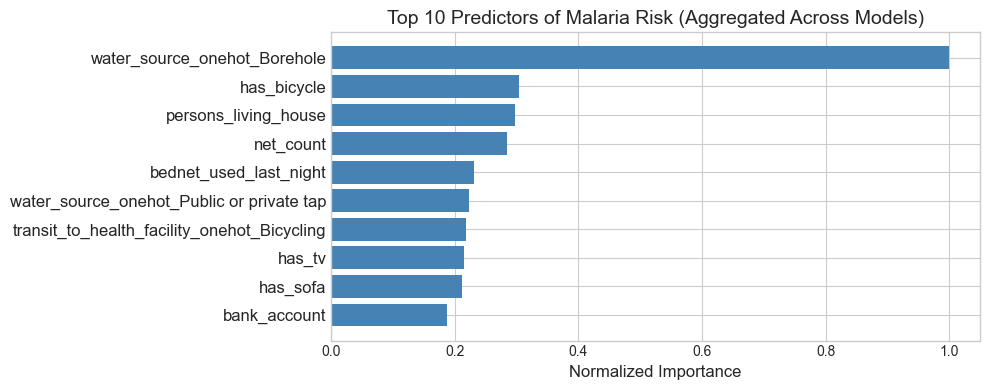

In [74]:
# Print and save key predictors
print("\nTop 20 Key Predictors of Malaria Risk:")
top_20 = key_predictors.head(20)
for i, (feature, importance) in enumerate(zip(top_20['Feature'], top_20['Normalized_Importance'])):
    print(f"{i+1}. {feature} (Normalized Importance: {importance:.4f})")

# Plot top 10 key predictors using matplotlib
top_10 = key_predictors.head(10)

plt.figure(figsize=(10, 4))
features = top_10['Feature'].values
importances = top_10['Normalized_Importance'].values

# Sort the data by importance
sorted_indices = np.argsort(importances)
features = features[sorted_indices]
importances = importances[sorted_indices]

# Plot
y_pos = np.arange(len(features))
plt.barh(y_pos, importances, color='steelblue')
plt.yticks(y_pos, features)
plt.xlabel('Normalized Importance', fontsize=12)
plt.title('Top 10 Predictors of Malaria Risk (Aggregated Across Models)', fontsize=14)
plt.tight_layout()
plt.savefig('./figures/key_predictors.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


### Model Development and Tuning

In [ ]:
# Load dataset
df = pd.read_csv("df_clean.csv")

# Separate features and target
X = df.drop(columns=["malaria"])
y = df["malaria"]

# # Check class imbalance
# class_counts = y.value_counts()
# print(f"Class distribution before SMOTE:\n{class_counts}")
# print(f"Imbalance ratio: 1:{class_counts[0]/class_counts[1]:.2f}")

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=99)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=99)

# Define models and hyperparameter grids
models = {
    "Logistic Regression": (LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear"), {}),
    "Random Forest": (
        RandomForestClassifier(class_weight="balanced", random_state=99),
        {
            "n_estimators": [100],
            "max_depth": [5, 10],
            "min_samples_leaf": [1, 2],
            "max_features": ["sqrt"]
        }
    ),
    "Gradient Boosting": (
        GradientBoostingClassifier(random_state=99),
        {
            "n_estimators": [100],
            "learning_rate": [0.1, 0.05],
            "max_depth": [3, 5],
            "min_samples_leaf": [1, 2]
        }
    ),
    "XGBoost": (
        XGBClassifier(random_state=99, eval_metric='logloss'),
        {
            "n_estimators": [100],
            "learning_rate": [0.1, 0.05],
            "max_depth": [3, 5],
            "min_child_weight": [1, 3]
        }
    )
}

# Create storage for plots
all_tpr = {}
all_fpr = {}
all_precision = {}
all_recall = {}
mean_auc = {}
mean_pr_auc = {}
colors = ['blue', 'green', 'orange', 'red']

# Evaluation storage
results = []

# Final test set for plotting curves
X_train, X_test, y_train, y_test = train_test_split(X_resampled, 
                                                    y_resampled, 
                                                    test_size=0.2, 
                                                    random_state=99, 
                                                    stratify=y_resampled)

# Loop through models
for i, (model_name, (model, param_grid)) in enumerate(models.items()):
    print(f"Training {model_name}...")
    grid = GridSearchCV(model, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_resampled, y_resampled)
    best_model = grid.best_estimator_
    
    # Cross-validation metrics
    auc_scores = []
    acc_scores = []
    prec_scores = []
    recall_scores = []
    f1_scores = []
    spec_scores = []  # Specificity scores
    balanced_acc_scores = []  # Balanced accuracy scores
    pr_auc_scores = []  # Precision-Recall AUC scores
    g_mean_scores = []  # Geometric mean scores
    mcc_scores = []  # Matthews Correlation Coefficient
    
    # For confusion matrix
    total_tn, total_fp, total_fn, total_tp = 0, 0, 0, 0
    
    # Create storage for ROC curve data
    tprs = []
    fprs = []
    aucs = []
    base_fpr = np.linspace(0, 1, 100)

    for train_idx, test_idx in cv.split(X_resampled, y_resampled):
        X_fold_train, X_fold_test = X_resampled.iloc[train_idx], X_resampled.iloc[test_idx]
        y_fold_train, y_fold_test = y_resampled.iloc[train_idx], y_resampled.iloc[test_idx]
        
        model_fold = grid.best_estimator_
        model_fold.fit(X_fold_train, y_fold_train)
        y_pred = model_fold.predict(X_fold_test)
        y_prob = model_fold.predict_proba(X_fold_test)[:, 1]

        # Base metrics
        auc_scores.append(roc_auc_score(y_fold_test, y_prob))
        acc_scores.append(accuracy_score(y_fold_test, y_pred))
        prec_scores.append(precision_score(y_fold_test, y_pred))
        recall_scores.append(recall_score(y_fold_test, y_pred))
        f1_scores.append(f1_score(y_fold_test, y_pred))
        
        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_fold_test, y_pred).ravel()
        total_tn += tn
        total_fp += fp
        total_fn += fn
        total_tp += tp
        
        # Calculate specificity (true negative rate)
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        spec_scores.append(specificity)
        
        # Calculate balanced accuracy
        balanced_acc = (recall_scores[-1] + specificity) / 2
        balanced_acc_scores.append(balanced_acc)
        
        # Calculate precision-recall AUC
        pr_auc = average_precision_score(y_fold_test, y_prob)
        pr_auc_scores.append(pr_auc)
        
        # Calculate geometric mean (G-mean)
        g_mean = np.sqrt(recall_scores[-1] * specificity)
        g_mean_scores.append(g_mean)
        
        # Calculate Matthews Correlation Coefficient
        numerator = (tp * tn) - (fp * fn)
        denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
        mcc = numerator / denominator if denominator != 0 else 0
        mcc_scores.append(mcc)
        
        # Get ROC curve data
        fpr, tpr, _ = roc_curve(y_fold_test, y_prob)
        tprs.append(np.interp(base_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        aucs.append(auc_scores[-1])

    # Fit final model on full test set for curve visualization
    best_model.fit(X_train, y_train)
    y_proba = best_model.predict_proba(X_test)[:, 1]
    
    # For ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    all_fpr[model_name] = fpr
    all_tpr[model_name] = tpr
    mean_auc[model_name] = roc_auc_score(y_test, y_proba)
    
    # For Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    all_precision[model_name] = precision
    all_recall[model_name] = recall
    mean_pr_auc[model_name] = average_precision_score(y_test, y_proba)
    
    # Calculate aggregate metrics
    auc_mean = np.mean(auc_scores)
    auc_ci = 1.96 * np.std(auc_scores) / np.sqrt(len(auc_scores))
    auc_formatted = f"{auc_mean:.3f} ({auc_mean - auc_ci:.3f}-{auc_mean + auc_ci:.3f})"
    
    # Calculate macro-averaged metrics from confusion matrix
    specificity = total_tn / (total_tn + total_fp) if (total_tn + total_fp) > 0 else 0
    sensitivity = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    balanced_acc = (sensitivity + specificity) / 2
    
    results.append({
        "Model": model_name,
        "AUC (95% CI)": auc_formatted,
        "Accuracy": np.mean(acc_scores),
        "Precision": np.mean(prec_scores),
        "Recall": np.mean(recall_scores),
        "F1 Score": np.mean(f1_scores),
        "Specificity": np.mean(spec_scores),
        "Balanced Acc": np.mean(balanced_acc_scores),
        "PR-AUC": np.mean(pr_auc_scores),
        "G-Mean": np.mean(g_mean_scores),
        "MCC": np.mean(mcc_scores)
    })

# Create a DataFrame for results
results_df = pd.DataFrame(results)
# Save results to CSV file
results_df.to_csv('model_evaluation_results.csv', index=False)

Training Logistic Regression...
Training Random Forest...
Training Gradient Boosting...


### Model Evaluation

add results here...

In [ ]:
# ROC Curve Plot
plt.figure(figsize=(8, 6))
for i, model_name in enumerate(models.keys()):
    plt.plot(all_fpr[model_name], all_tpr[model_name], lw=2, color=colors[i], 
             label=f'{model_name} (AUC = {mean_auc[model_name]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig('./figures/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# Precision-Recall Curve Plot
plt.figure(figsize=(8, 6))
for i, model_name in enumerate(models.keys()):
    plt.plot(all_recall[model_name], all_precision[model_name], lw=2, color=colors[i], 
             label=f'{model_name} (PR-AUC = {mean_pr_auc[model_name]:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.savefig('./figures/precision_recall_curves.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# Metrics Comparison Bar Chart
plt.figure(figsize=(10, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity', 'Balanced Acc', 'G-Mean']
model_names = results_df['Model'].tolist()
blueColours = ['#42A5F5', '#90CAF9', '#0D47A1', '#1976D2'];
x = np.arange(len(metrics))
width = 0.2
multiplier = 0

for i, model_name in enumerate(model_names):
    offset = width * multiplier
    values = [results_df.loc[i, metric] for metric in metrics]
    plt.bar(x + offset, values, width, label=model_name, color=blueColours[i], alpha=0.8)
    multiplier += 1

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Performance Metrics Comparison')
plt.xticks(x + width * (len(model_names) - 1) / 2, metrics, rotation=45)
plt.ylim(0, 1.0)
plt.yticks(fontsize=10)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=4)
plt.tight_layout()
plt.grid(True, alpha=0.3, axis='y')
plt.savefig('./figures/metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# Plot the Confusion Matrix Visualization - for the best model
best_model_idx = results_df['F1 Score'].argmax()
best_model_name = results_df.iloc[best_model_idx]['Model']
best_model = models[best_model_name][0]
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.colorbar()
plt.grid(False)  # Disable grid lines

classes = ['Negative', 'Positive']

# Add text annotations
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig('./figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# Create a formatted table for display
print("\nComplete Model Evaluation Results:")
formatted_df = results_df.copy()
for col in formatted_df.columns:
    if col not in ["Model", "AUC (95% CI)"]:
        formatted_df[col] = formatted_df[col].apply(lambda x: f"{x:.3f}")
print(formatted_df)

In [ ]:
end = time()

# Calculate the total time taken to run the
# code in minutes and seconds
elapsed = end - start
minutes = int(elapsed // 60)
seconds = elapsed % 60

# Display in minutes and seconds format
print(f"Time: {minutes}m {seconds:.2f}s")